# Experiment organization
Goal: Gather results from all topic modeling experiments using many stemming treatments for a particular corpus, then creates some visualizations.
The expected tree structure for the corpus and experiments is as follows:
```
<corpus> # corpus name - 'tiger','rnc' or 'opencorpora'
├── <corpus>_<stemmer> # stemmer or lemmatization treatment name, see topic_modeling/stemming.py for language details
│   ├── <corpus_oracleAnalysis.gz # Only present when stemmer=='oracle', the annotation labels for the words in the corpus, in sequence to match up with state files
│   ├── <corpus>_<stemmer>.mallet # mallet import-dir --output
│   ├── <corpus>_<stemmer>.tsv # output of topic_modeling/corpus_preprocessing.py for this particular treatment
│   ├── <corpus>_<stemmer>_<num_topics>_topics_<num_iters>_iters_<experiment_id> 
│   │   ├── <corpus>_<stemmer>_diagnostics.tsv # mallet train-topics metrics as tsv
│   │   ├── <corpus>_<stemmer>_diagnostics.xml # original mallet train-topics metrics format
│   │   ├── <corpus>_<stemmer>_doc_topics.txt # mallet train-topics --output-doc-topics 
│   │   ├── <corpus>_<stemmer>_entropy_metrics.tsv # metrics produced by by topic_modeling/mallet_parser slot-entropy
│   │   ├── <corpus>_<stemmer>.model # mallet topic model 
│   │   ├── <corpus>_<stemmer>_postLemmatized_diagnostics.tsv # mallet train-topics metrics for the version of this model lifted to lemmas 
│   │   ├── <corpus>_<stemmer>_postLemmatized_diagnostics.xml 
│   │   ├── <corpus>_<stemmer>_postLemmatized.mallet # mallet corpus sequence file lifted to lemmas (we probably only need to create this once, but I didn't think of that earlier, so for now each experiment gets its own)
│   │   ├── <corpus>_<stemmer>_postLemmatized.model # mallet topic model lifted to lemmas
│   │   ├── <corpus>_<stemmer>_postLemmatized_state.gz # mallet topic model state file lifted to 
│   │   ├── <corpus>_<stemmer>_state.gz # mallet topic model state file
│   │   ├── <corpus>_<stemmer>_top_docs.txt # mallet train-topics --output-doc-topics 
│   │   ├── <corpus>_<stemmer>_topic_keys.txt # mallet train-topics --output-topic-keys
│   │   ├── <corpus>_<stemmer>_topic_lemmas.tsv # Counts and conditional probablilities of lemmas for each topic
│   │   ├── <corpus>_<stemmer>_topic_pos.tsv  # Counts and conditional probablilities of parts-of-speech for each topic
│   │   ├── <corpus>_<stemmer>_topic_slots.tsv  # Counts and conditional probablilities of detailed morphological analyses for each topic
│   │   └── <corpus>_<stemmer>_top_terms.tsv # Raw counts of top 20 terms for each topic
└── voi_<num_topics>_topics # Variation of information between different models for the same number of topics
    └── <corpus>_<stemmer1>_<experiment1_id>_<corpus>_<stemmer2>_<experiment2_id>.tsv # Compares treatment 1 and treatment 2 

```



In [1]:
from pathlib import Path 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import stats
from topic_modeling import mallet_parser

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="white")

In [2]:
def parse_experiment_directory(experiment_path):
    """Parses out all topic level metrics from a topic model's TSV results file, given the model's path. 
    Returns topic level metrics as a dataframe
    """
    dir_name = experiment_path.name
    split_name = dir_name.split("_")
    corpus = split_name[0]
    treatment = split_name[1]
    num_topics = split_name[2]
    experiment_id = split_name[-1]
    original_mallet_diagnostics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_diagnostics.tsv", sep="\t", index_col="id", na_filter=False)

    final_frame = original_mallet_diagnostics
    final_frame['negative_coherence'] = - final_frame['coherence']

    final_frame.insert(loc = 0, column="corpus", value = corpus)
    final_frame.insert(loc = 1, column="treatment", value=treatment)
    final_frame.insert(loc = 2, column="num_topics", value=int(num_topics))
    final_frame.insert(loc = 3, column="experiment_id", value = experiment_id)

    lemma_mallet_diagnostics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_postLemmatized_diagnostics.tsv", sep="\t", index_col="id")
    lemma_mallet_diagnostics.rename(columns = {"exclusivity":"lemma_exclusivity"}, inplace=True)
    
    final_frame["lemma_exclusivity"] = lemma_mallet_diagnostics["lemma_exclusivity"]

    entropy_metrics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_entropy_metrics.tsv", sep = "\t", index_col="topic")

    final_frame = pd.merge(final_frame, entropy_metrics, left_index= True, right_index = True)
    final_frame = final_frame.reset_index().rename(columns={"id":"topic_id"})

    return final_frame

def parse_voi_tsv(voi_tsv):
    """Returns a dataframe for the VOI results in a single VOI tsv output.
    """
    split_name = voi_tsv.name[:-4].split("_")
    stemmer_a = split_name[1]
    a_exp_id = split_name[2]
    stemmer_b = split_name[4]
    b_exp_id = split_name[5]
    voi_frame = pd.read_csv(voi_tsv, sep="\t", index_col=False, names = ["a_path", "b_path", "voi"])
    voi_frame["treatment_a"] = stemmer_a
    voi_frame["a_experiment_id"] = a_exp_id
    voi_frame["treatment_b"] = stemmer_b
    voi_frame["b_experiment_id"] = b_exp_id
    if stemmer_a != stemmer_b:
        # VOI is symmetric, so flip them too
        flipped_df = voi_frame.copy()
        flipped_df["treatment_a"] = stemmer_b
        flipped_df["a_experiment_id"] = b_exp_id
        flipped_df["treatment_b"] = stemmer_a
        flipped_df["b_experiment_id"] = a_exp_id
        voi_frame = pd.concat([voi_frame, flipped_df], ignore_index=True)
    return voi_frame

def parse_voi_directory(voi_path):
    """Parses out all VOI comparisons between experiments from the TSVs in the VOI directory.
    Returns all VOI comparisons as a dataframe
    """
    tsvs = voi_path.glob("*.tsv")
    return pd.concat([parse_voi_tsv(t) for t in tsvs], ignore_index=True, sort=False)

# Corpus stats

In [3]:
corpus_name = "tiger"
corpus_root = Path("/home/virginia/workspace/topic-modeling-study") / corpus_name
experiment_folders = list(corpus_root.glob(f"{corpus_name}_*/*_topics_*_iters_*"))
oracle_gz = corpus_root / f"{corpus_name}_oracle/{corpus_name}_oracleAnalysis.gz"
voi_folders = list(corpus_root.glob("voi_*"))
corpus_stats_tsv = corpus_root / f"{corpus_name}_corpus_stats.tsv"
print("Num experiment folders found:", len(experiment_folders))
print("Oralce gzip path:", oracle_gz)
print("VOI folders:", voi_folders)

# How to order treatments in plots
hue_order = ["raw", "oracle", "spacy", "stanza", "snowball", "truncate6", "truncate5"]

Num experiment folders found: 140
Oralce gzip path: /home/virginia/workspace/topic-modeling-study/tiger/tiger_oracle/tiger_oracleAnalysis.gz
VOI folders: [PosixPath('/home/virginia/workspace/topic-modeling-study/tiger/voi_100_topics'), PosixPath('/home/virginia/workspace/topic-modeling-study/tiger/voi_50_topics')]


,treatment,token_count,word_type_count,type_to_token_ratio,char_to_token_ratio
0,raw,310925,73633,0.236819,8.92389
1,oracle,310925,55498,0.178493,8.50997
2,spacy,310925,60730,0.195320,8.61280
3,snowball,310925,53859,0.173222,7.61651
4,stanza,310925,37373,0.120199,7.57288
5,truncate5,310925,21059,0.067730,4.87998
6,truncate6,310925,30509,0.098123,5.70368


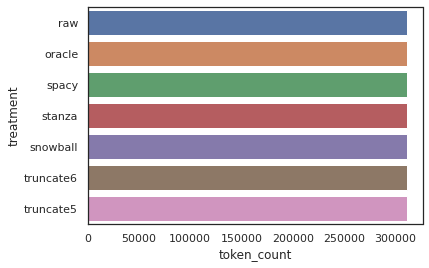

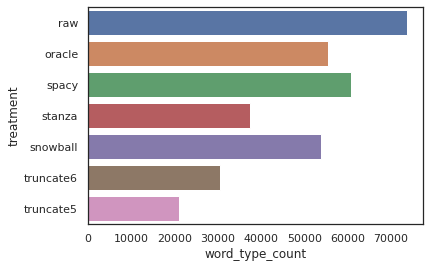

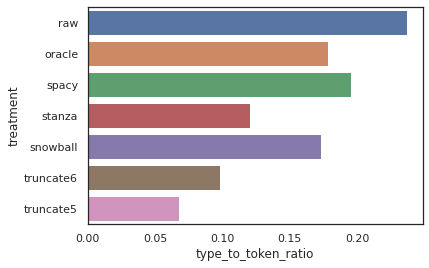

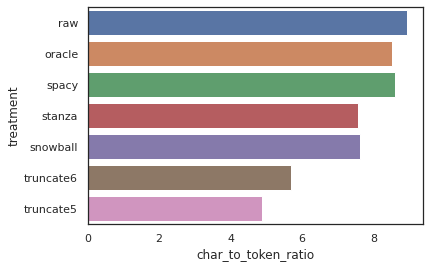

In [4]:
stat_cols = ['token_count', 'word_type_count', 'type_to_token_ratio', 'char_to_token_ratio']
stats_frame = pd.read_csv(corpus_stats_tsv, sep="\t", index_col=False)
display(stats_frame)

for i, c in enumerate(stat_cols):
    plt.figure(i)
    sns.barplot(data = stats_frame, x=c, y="treatment", order=hue_order)

In [5]:
# Concat all experiment results together, save off results
full_frame = pd.concat([parse_experiment_directory(f) for f in experiment_folders], ignore_index=True, sort=False)
print("Total entries:", len(full_frame))
full_frame.to_csv(corpus_root / f'{corpus_name}_all_experiments_metrics.tsv', sep='\t', index=False)
full_frame.head(3)

Total entries: 10500


,topic_id,corpus,treatment,num_topics,experiment_id,tokens,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity,negative_coherence,lemma_exclusivity,lemma_entropy,slot_entropy,pos_entropy,lemmas_to_top_20_surface_forms,slots_to_top_20_surface_forms,pos_to_top_20_surface_forms,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,top_term_lemmas_minus_top_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms,num_top_term_lemmas_excluded_by_top_lemmas
0,0,tiger,snowball,50,8,2179.0,2.7255,5.70,-550.8188,4.1669,4.1999,365.4870,0.0394,0.2895,0.0000,0.2105,0.5816,550.8188,0.5911,9.748793,5.874976,2.106239,1.20,3.20,0.25,famili madch nachricht rizal ard pleitg fernseh mannlich mann wein philippin manila alltag frau spanisch kind flasch zdf indisch indi,philippinen männlich indien aguinaldo mädchen rizal pleitgen ard tempel mann wein manila familie frau fernsehen spanisch kind zdf flasche indisch,philippinen fernseher männlich indien mädchen nachricht rizal pleitgen ard nachrichtlich alltäglich mann wein manila philippinisch alltag familie frau fernsehen spanisch kind zdf flasche indisch,tempel aguinaldo,nachrichtlich alltäglich nachricht fernseher philippinisch alltag,24,2,6
1,1,tiger,snowball,50,8,6557.0,5.2022,5.55,-345.4964,4.3083,2.8697,289.8886,0.0061,0.1022,0.0737,0.0884,0.4716,345.4964,0.4467,9.633572,5.595342,2.234368,1.35,2.50,0.40,afp dpa stadt polizist ap opf verletzt polizei mensch mann gefang soldat sonntag getotet mindest novemb frau hauptstadt arme angab,afp dpa stadt polizist ap schwer november angabe polizei mensch mann soldat sonntag armee opfer frau hauptstadt verletzen mindestens töten,afp dpa polizeilich stadt getötet polizist ap angeben november angabe verletzt polizei mensch mann sonntäglich soldat sonntag armee verletzter gefangen frau opfer hauptstadt gefangener verletzen mindestens töten,schwer,sonntäglich polizeilich getötet angeben gefangen verletzt verletzter gefangener,27,1,8
2,2,tiger,snowball,50,8,26650.0,6.7538,6.10,-334.1139,4.2230,1.7709,408.2471,0.0012,0.0495,0.0020,0.0572,0.4937,334.1139,0.4586,9.802577,5.604329,2.744263,2.20,4.35,0.55,dpa entscheid deutsch bonn vertret polit regier geplant freitag bericht sprech fordert seit novemb muss dienstag montag gesprach erklart woch,regierung können dpa erklären woche deutsch bonn entscheidung präsident november gespräch fordern geplant freitag bericht müssen sprechen dienstag montag seite,sprecher regierung dpa montags planen erklären montage woche gesprächig deutsch bonn entscheidung fördern dienstags vertreten november gespräch fordern vertreter seitens geplant freitag müssen politisch bericht erklärt entscheidend politiken entscheiden berichten seiters muße deutsche politiker sprechen montag dienstag freitags montäglich politik seite bonner regierend vertretung,können präsident,sprecher gesprächig montags planen montage fördern dienstags vertreten vertreter seitens politisch erklärt entscheidend politiken entscheiden berichten seiters muße deutsche politiker freitags montäglich politik bonner regierend vertretung,44,2,26


In [6]:
num_topics = [50, 100]
num_topics_splits = []
for t in num_topics:
    topic_df = full_frame[full_frame["num_topics"] == t]
    num_topics_splits.append((t, topic_df))

for t, df in num_topics_splits:
    print(t, "topics length:", len(df))



50 topics length: 3500
100 topics length: 7000


# Entropy metrics
Using the annotated corpus as the oracle for lemma, parts of speech and morphological analysis, what's the entropy of topics with respect the original to the grammatical forms of the original wordforms in the documents? 

The treated corpora should have lower lemma entropies, since lemmatiztion forces wordtypes with the same lemma to be together. We would also expect the treated corpora to have higher slot entropy than the raw corpus, because treatments conflate many wordforms with different morphological analyses, but this does not appear to be the case.

- 'raw' has most extreme mean in all cases of entropy metrics - low document entropy & high entropy for grammatical features
- 'raw' (no treatment) has higher lemma and morphological slot entropy than all other treatments. How can the untreated corpus get both higher average lemma entropy and higher average slot entropy? If our expectation is that all forms of a particular lemma concentrate in a given topic (low lemma entropy, high slot entropy), this finding runs counter to that expectation.

In [7]:
# Determine corpus level slot, lemma, pos entropy 
surface_form_counts, lemma_counts, slot_counts, pos_counts = mallet_parser.get_corpus_analysis_counts(oracle_gz)
print("Surface forms vocab size (should match raw vocab size):", len(surface_form_counts), "Sum:", sum(surface_form_counts.values()))
print("Lemma vocab size (should match oracle vocab size):", len(lemma_counts), "Sum:", sum(lemma_counts.values()))
print("Slot vocab size:", len(slot_counts), "Sum:", sum(slot_counts.values()))
print("POS vocab size:", len(pos_counts), "Sum:", sum(pos_counts.values()))

Surface forms vocab size (should match raw vocab size): 73560 Sum: 310925
Lemma vocab size (should match oracle vocab size): 55489 Sum: 310925
Slot vocab size: 427 Sum: 310925
POS vocab size: 42 Sum: 310925


In [8]:
corpus_lemma_entropy = mallet_parser.get_entropy_from_counts_dict(lemma_counts, sum(lemma_counts.values()))
corpus_slot_entropy = mallet_parser.get_entropy_from_counts_dict(slot_counts, sum(slot_counts.values()))
corpus_pos_entropy = mallet_parser.get_entropy_from_counts_dict(pos_counts, sum(pos_counts.values()))

print("Corpus lemma entropy:", corpus_lemma_entropy)
print("Corpus slot entropy:", corpus_slot_entropy)
print("Corpus POS entropy:", corpus_pos_entropy)

Corpus lemma entropy: 13.60780408131539
Corpus slot entropy: 6.036523935366754
Corpus POS entropy: 2.5817809473473585


<Figure size 432x288 with 0 Axes>

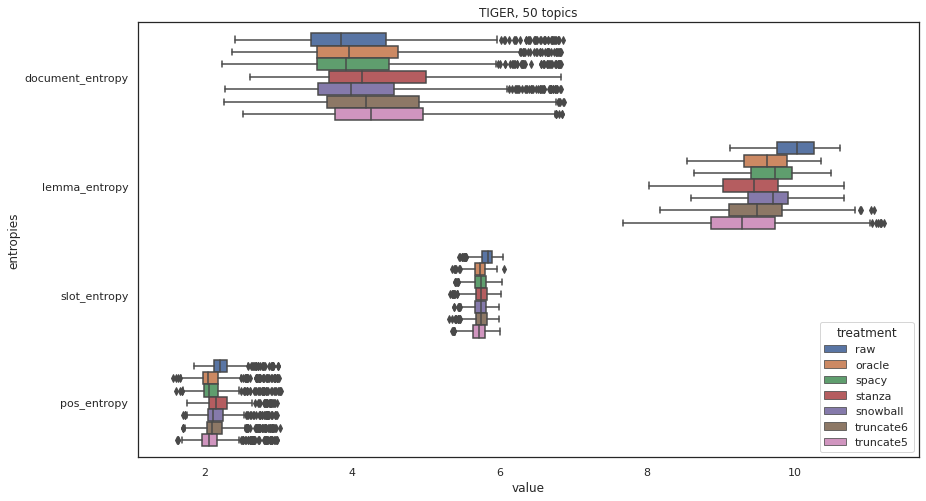

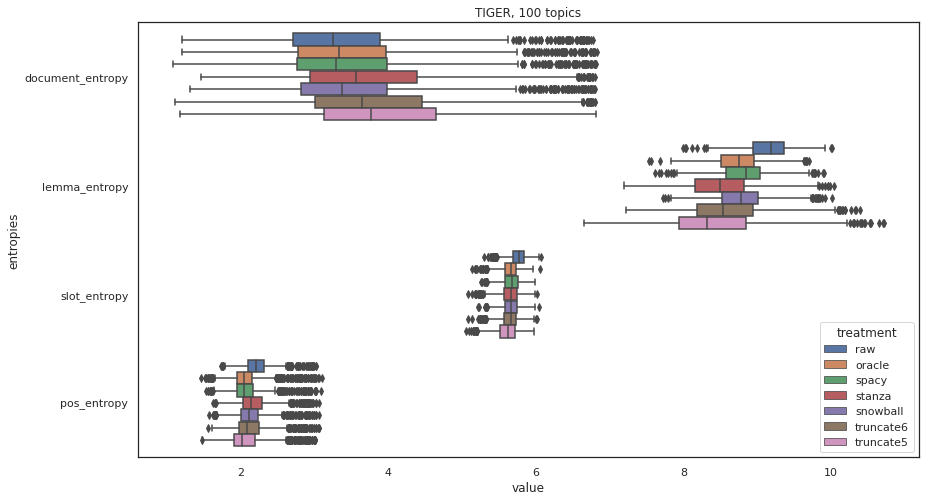

In [9]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    entropy_metrics = ['document_entropy', 'lemma_entropy', 'slot_entropy', 'pos_entropy']
    entropy_stats = pd.melt(df, "treatment", var_name="entropies", value_vars=entropy_metrics)
    plt.figure(i)
    fig, axs = plt.subplots(figsize=(14, 8))
    sns.boxplot(x="value", y="entropies", hue="treatment", data = entropy_stats, hue_order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

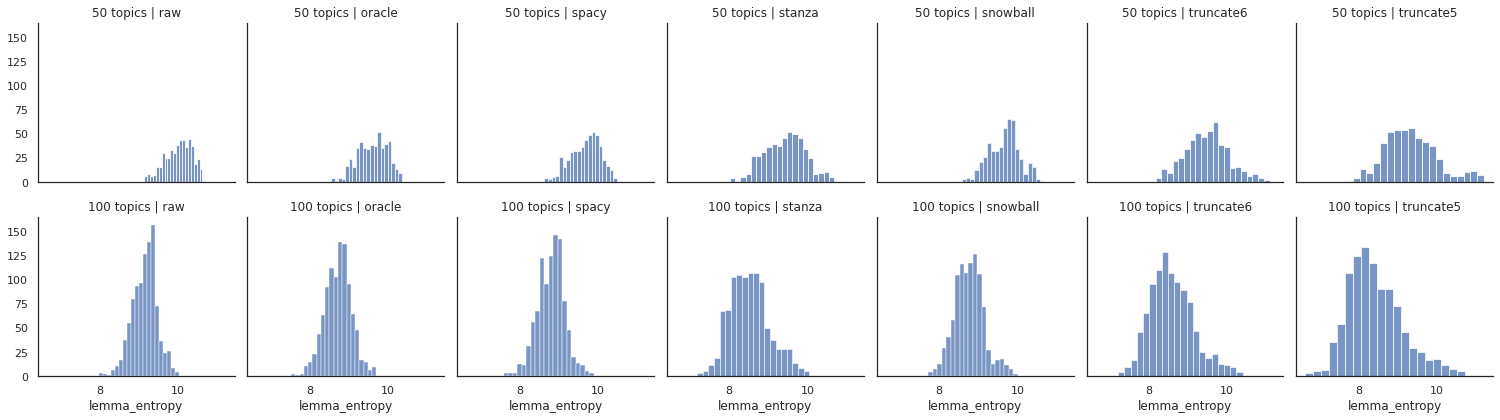

In [10]:
g = sns.FacetGrid(full_frame, col="treatment", row="num_topics", col_order=hue_order)
g.map(sns.histplot, "lemma_entropy", bins=20)
g.set_titles(col_template="{col_name}", row_template= "{row_name} topics")

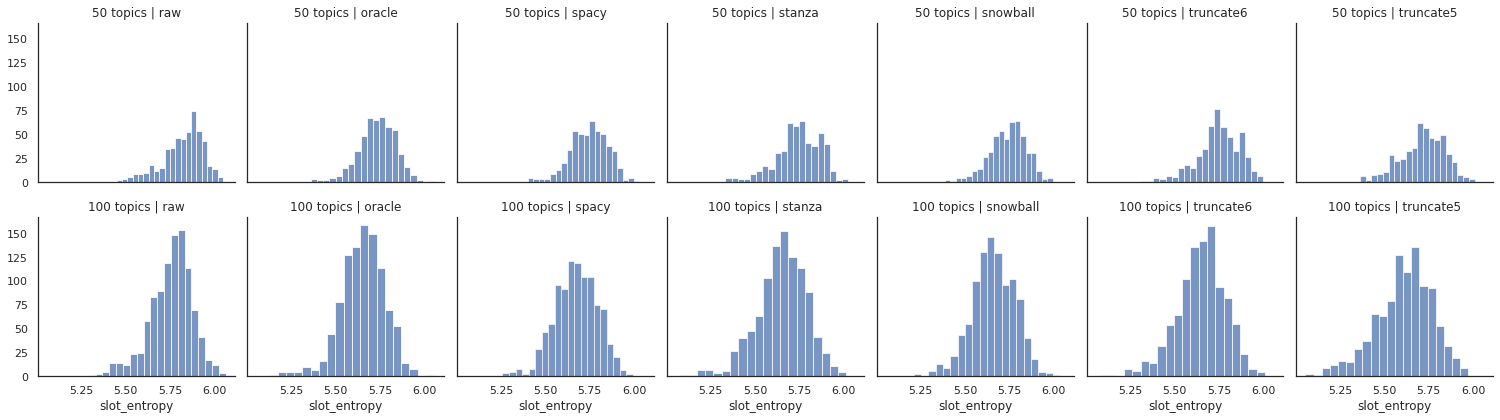

In [11]:
g = sns.FacetGrid(full_frame, col="treatment", row="num_topics", col_order=hue_order)
g.map(sns.histplot, "slot_entropy", bins=20)
g.set_titles(col_template="{col_name}", row_template= "{row_name} topics")

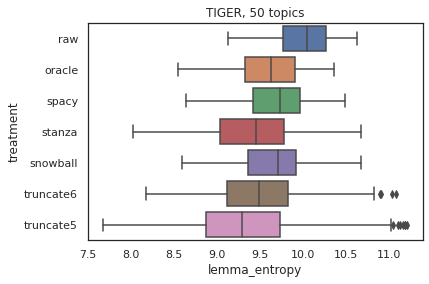

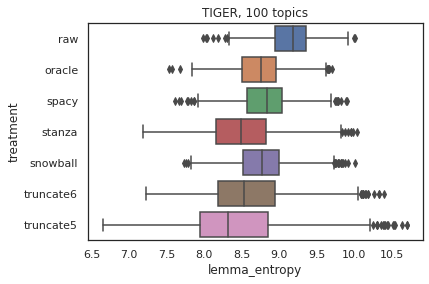

In [12]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='lemma_entropy', y='treatment', data=df, order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

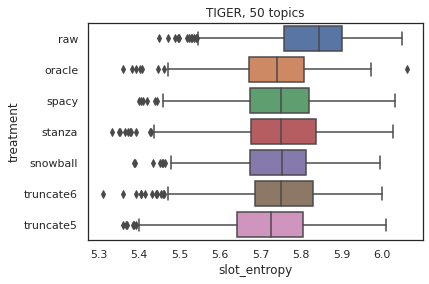

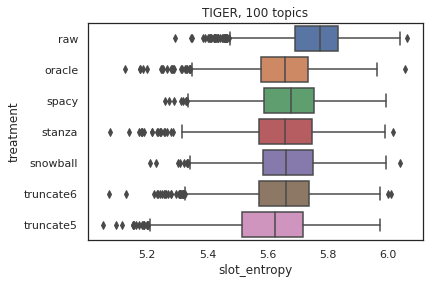

In [13]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='slot_entropy', y='treatment', data=df, order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

<Figure size 432x288 with 0 Axes>

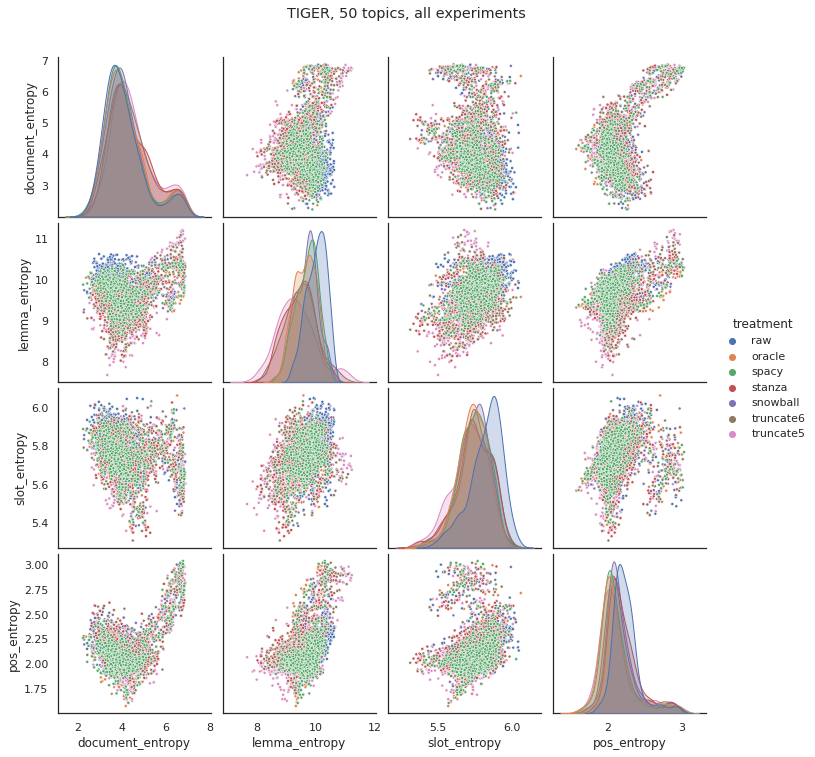

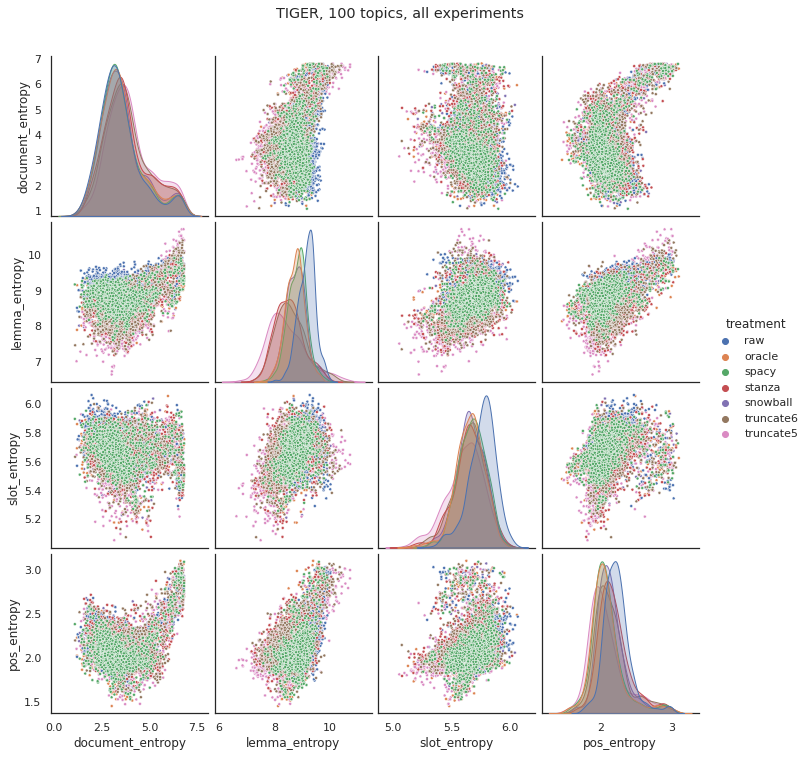

In [14]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    g = sns.pairplot(df, hue="treatment", vars=entropy_metrics, markers='.', hue_order=hue_order)
    g.fig.suptitle(f"{corpus_name.upper()}, {num_topics} topics, all experiments", y = 1.05)

<Figure size 432x288 with 0 Axes>

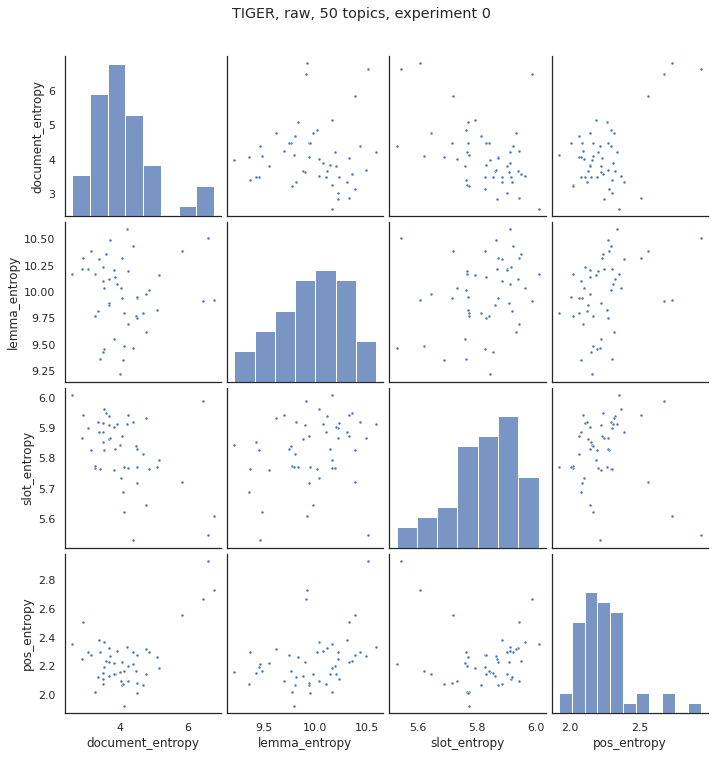

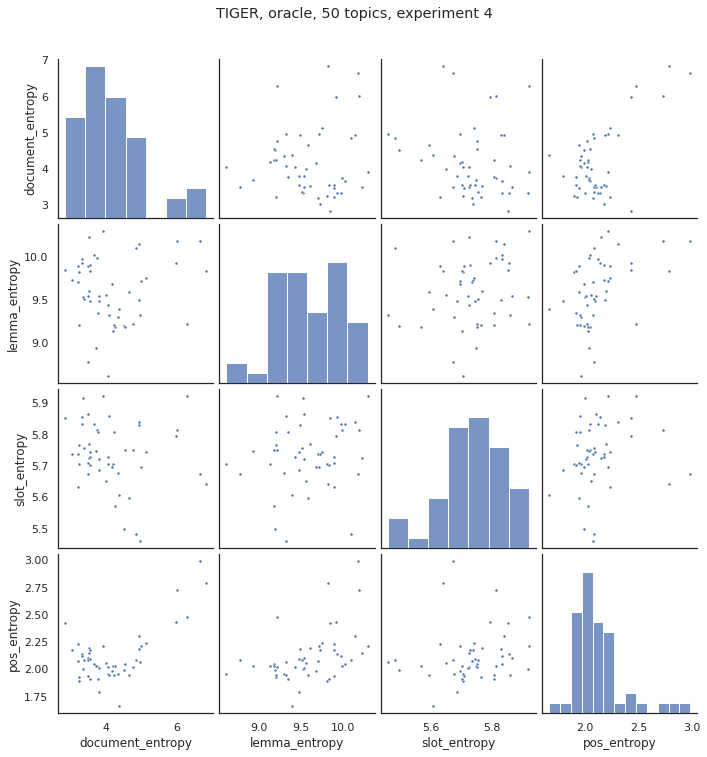

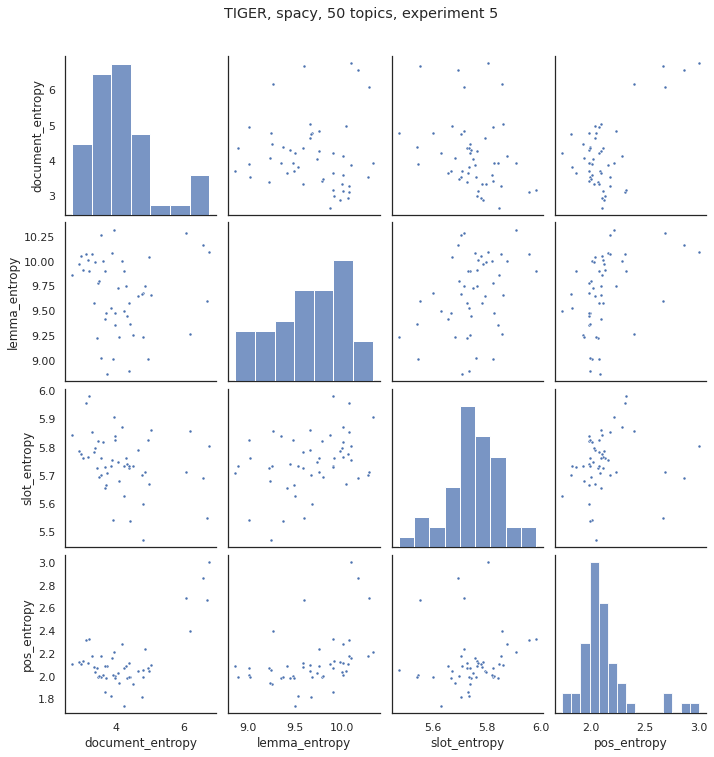

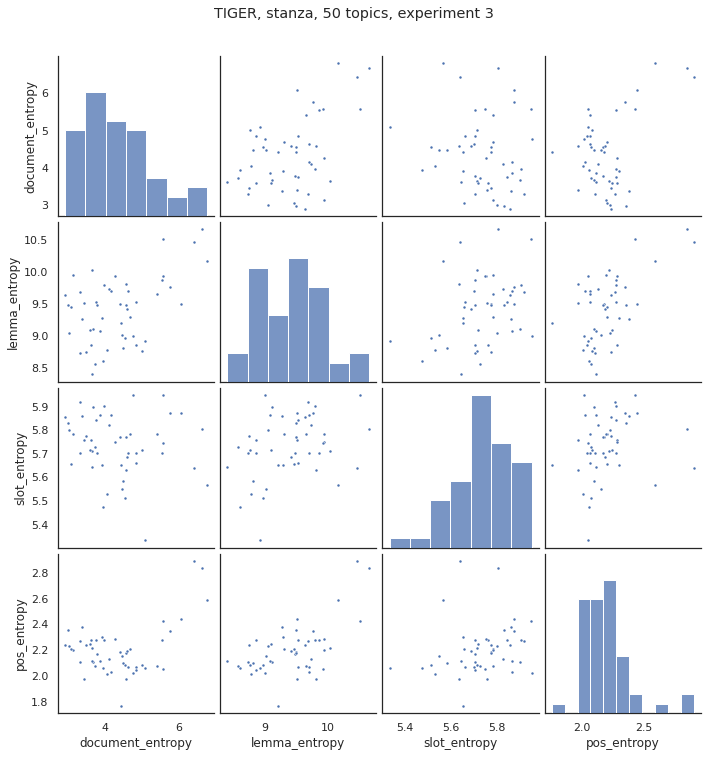

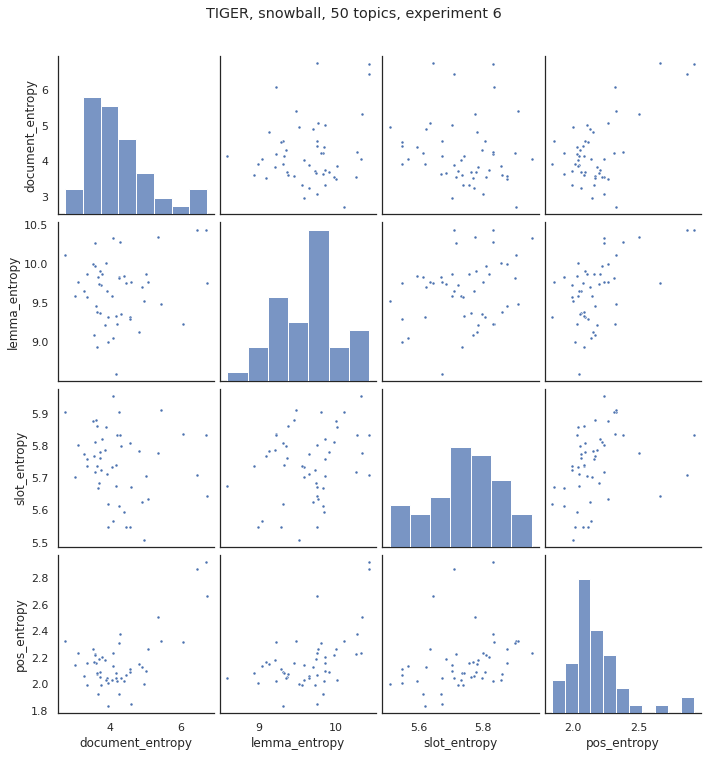

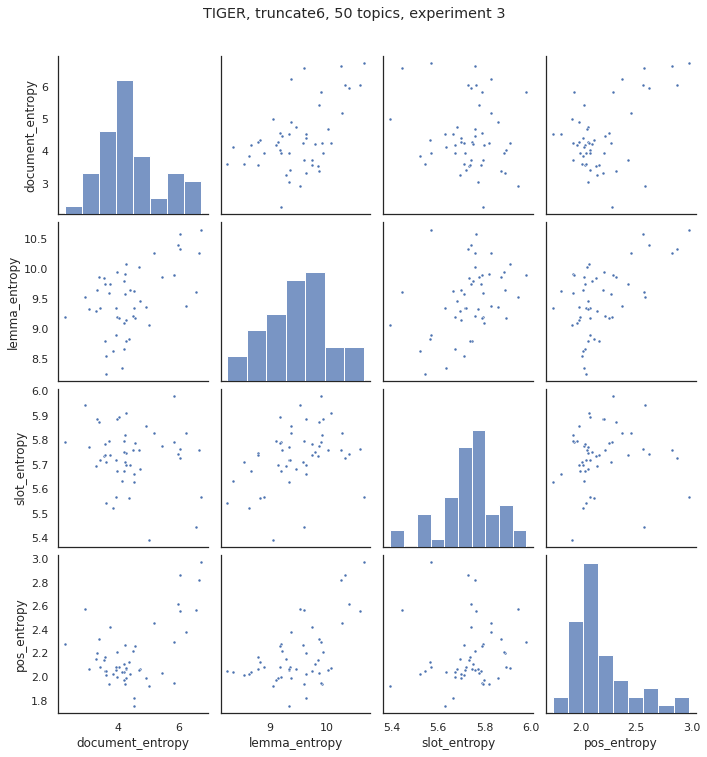

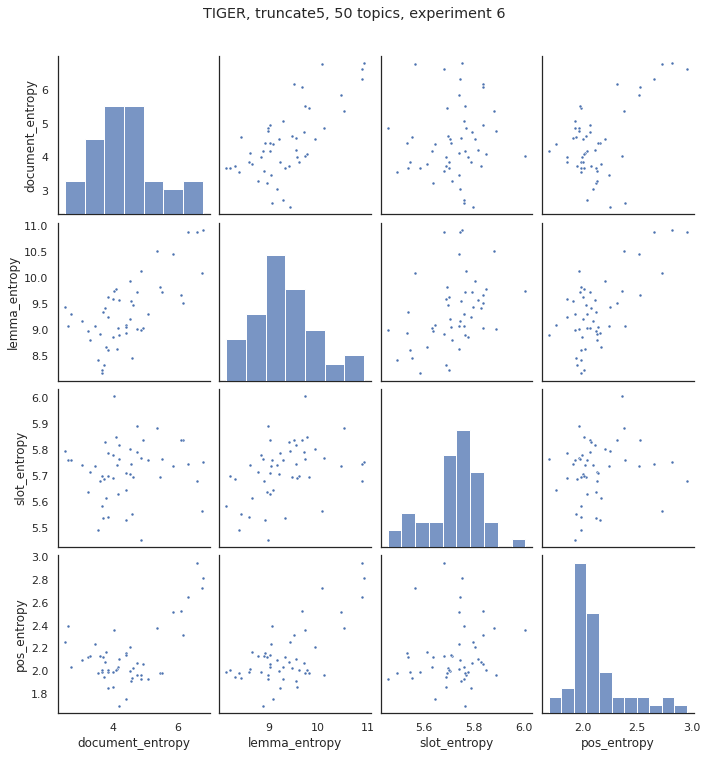

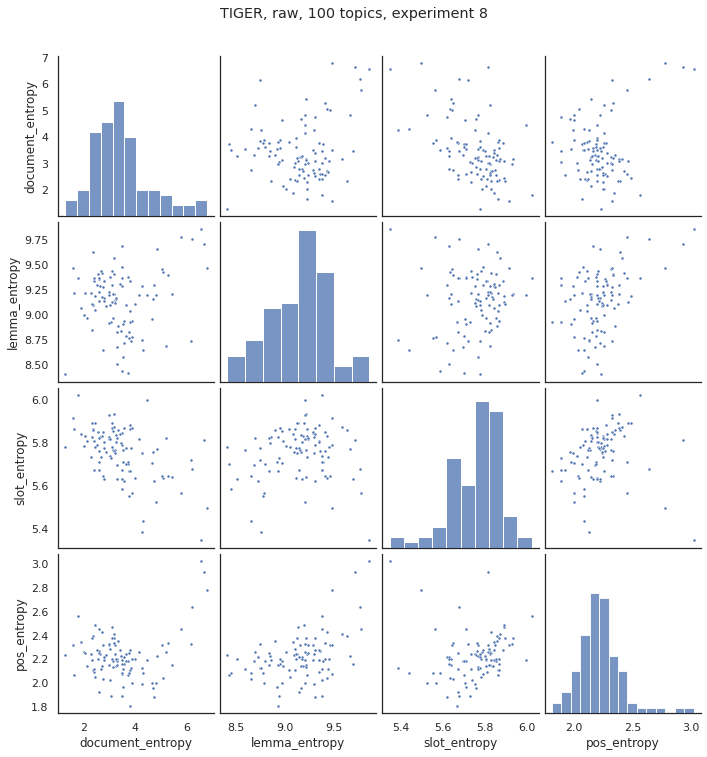

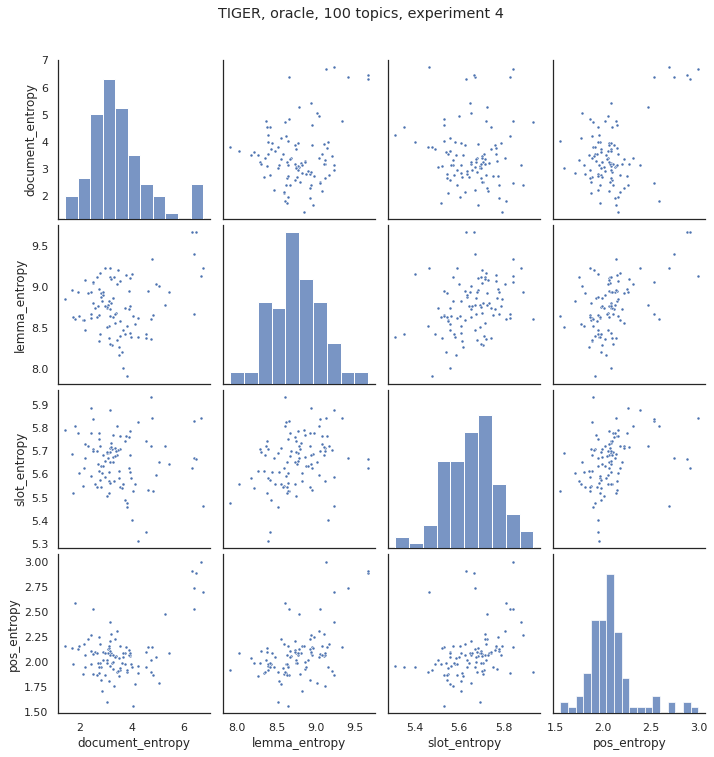

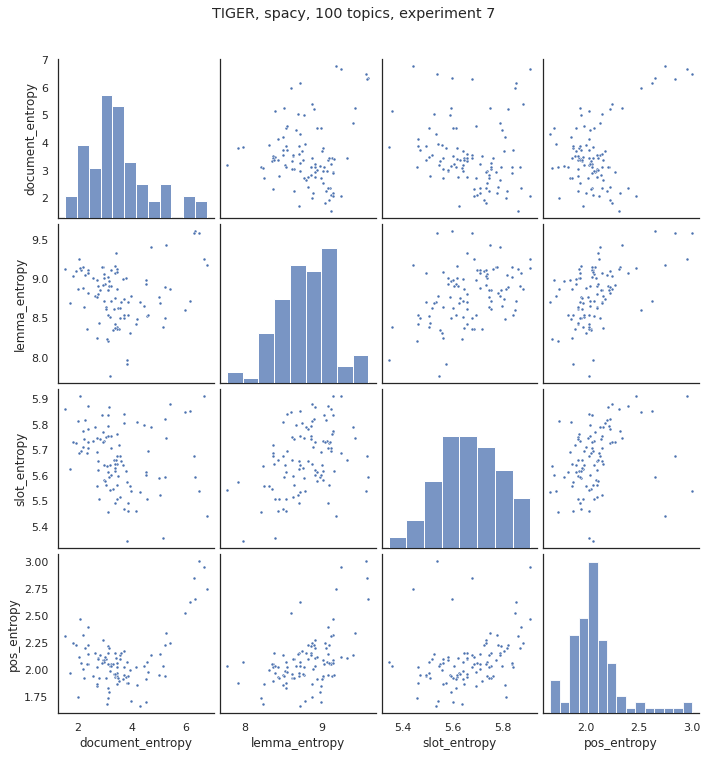

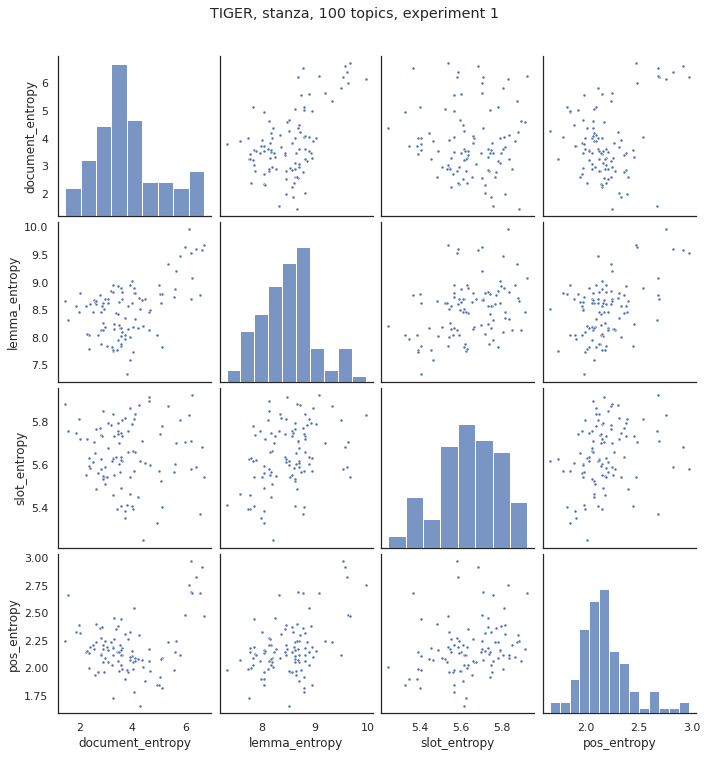

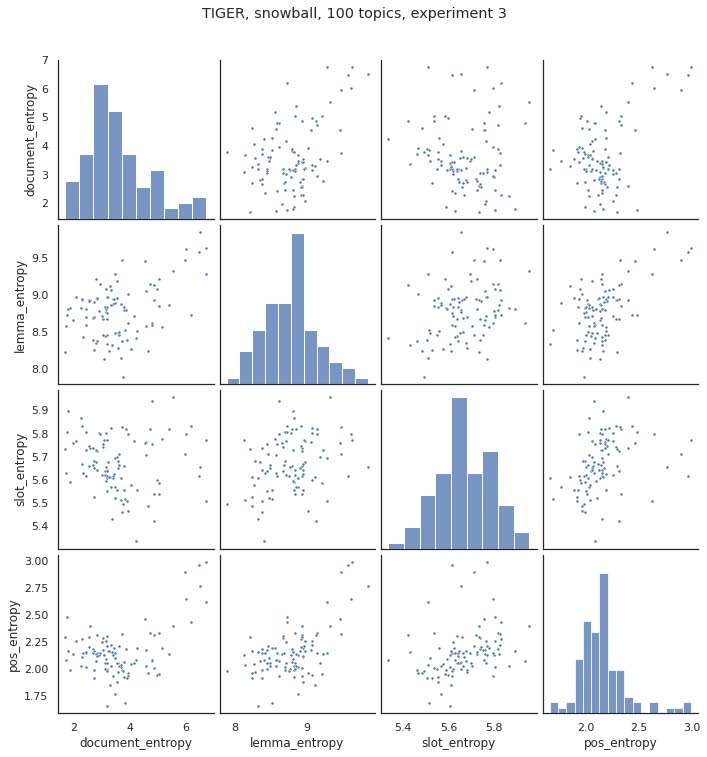

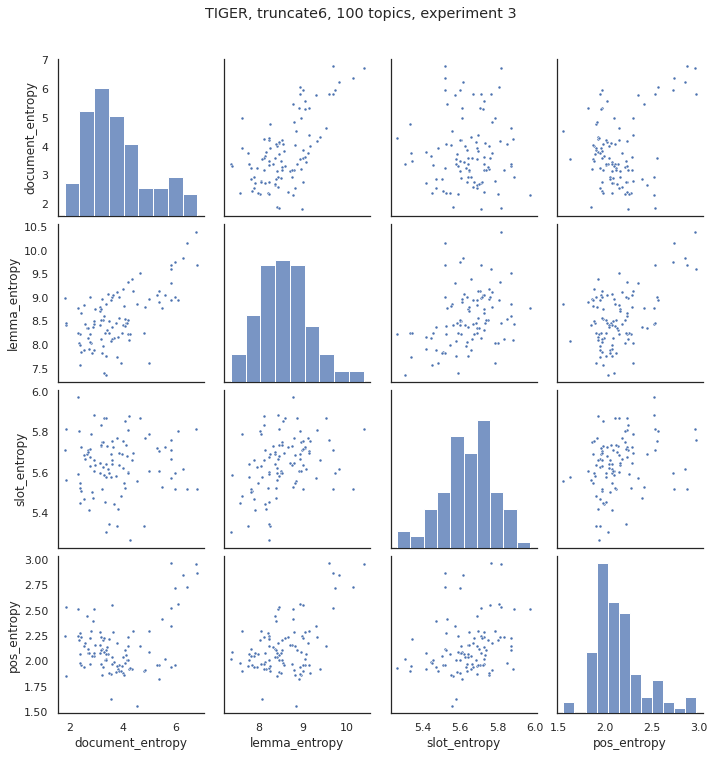

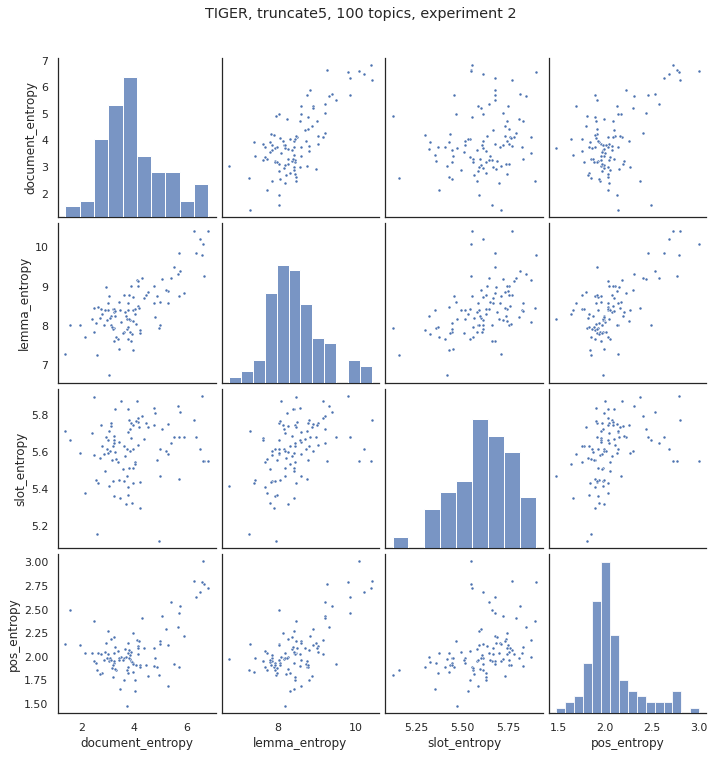

In [15]:
    # The same pair plots for a single experiment in each stemmer type
    counter = 0
    for i, pair in enumerate(num_topics_splits):
        num_topics, df = pair
        for treatment in hue_order:
            tmp_df = df[df['treatment'] == treatment]
            experiment_id = random.randrange(10)
            tmp_df = tmp_df[tmp_df['experiment_id'] == str(experiment_id)]
            plt.figure(counter)
            g = sns.pairplot(tmp_df, vars=entropy_metrics, markers='.')
            g.fig.suptitle(f"{corpus_name.upper()}, {treatment}, {num_topics} topics, experiment {experiment_id}", y = 1.05)
            counter+=1

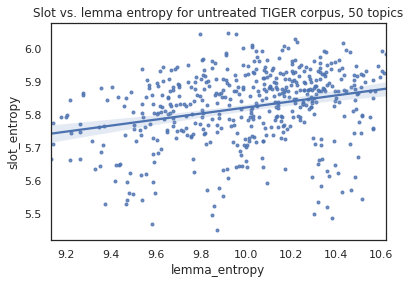

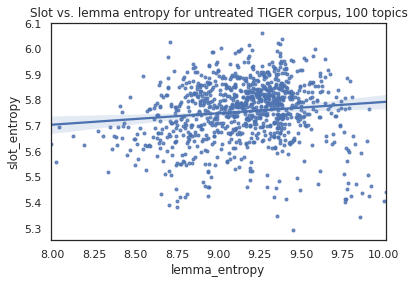

In [16]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    raw_df = df[df['treatment'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    sns.regplot(data=raw_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name.upper()} corpus, {num_topics} topics")

Slope: 0.09159192853630577 Intercept: 4.90598177063935 r: 0.27319244578518154 r^2: 0.07463411243408935
Slot entropy stddev: 0.11232388282288441
Lemma entropy stdev: 0.3350299175795652
Slope: 0.04431029127815401 Intercept: 5.349707285437052 r: 0.11597104929507358 r^2: 0.013449284274600386
Slot entropy stddev: 0.11918792866984651
Lemma entropy stdev: 0.31194444343369093


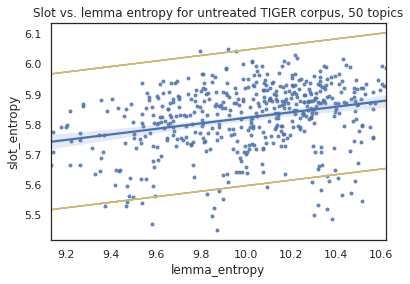

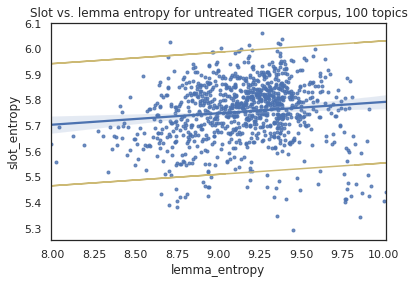

In [17]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    raw_df = df[df['treatment'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    x_data = raw_df["lemma_entropy"]
    y_data = raw_df["slot_entropy"]
    # Following https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(OpenStax)/12%3A_Linear_Regression_and_Correlation/12.07%3A_Outliers
    res = stats.linregress(x_data, y_data)
    print("Slope:", res.slope, "Intercept:", res.intercept, "r:", res.rvalue, "r^2:", res.rvalue**2)
    y_stdev = np.std(y_data)
    print("Slot entropy stddev:", y_stdev)
    x_stdev = np.std(x_data)
    print("Lemma entropy stdev:", x_stdev)
    plt.plot(x_data, res.intercept + res.slope*x_data + 2*y_stdev, 'y')
    plt.plot(x_data, res.intercept + res.slope*x_data - 2*y_stdev, 'y')
    sns.regplot(data=raw_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name.upper()} corpus, {num_topics} topics")

50 topic experiments, low lemma entropy: 16 topics


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
4643,3,43,50,9.132868,5.665710,chinas li kohls kohl china deutsche chinesischen hongkong peking pekinger bundeskanzler armee besuch vietnam helmut chinesische regierungschef deutschen kanzler zusammenarbeit,li kohl china deutsch hongkong peking pekinger bundeskanzler armee chinesisch besuch militär vietnam hanoi helmut regierungschef kanzler besuchen zusammenarbeit peng,regierungschef deutsche li deutsch kohls peking hongkong pekinger kanzler kohl bundeskanzler helmut chinesisch besuch armee china vietnam zusammenarbeit,militär peng besuchen hanoi,18,4
4679,8,29,50,9.142350,5.709831,helmut besuch deutschen wirtschaft bundeskanzler zusammenarbeit deutsche vietnam kohls chinas chinesische chinesischen peking pekinger regierungschef armee china kohl li kanzler,helmut militär chinesisch besuch hongkong wirtschaft bundeskanzler zusammenarbeit vietnam deutsch peking pekinger regierungschef vietnamese armee china kohl li kanzler westlich,wirtschaft armee bundeskanzler china kohl helmut zusammenarbeit deutsche chinesisch vietnam besuch deutsch kanzler li kohls peking pekinger regierungschef,vietnamese westlich militär hongkong,18,4
4983,2,33,50,9.142849,5.775048,republikanern republikaner us-regierung kongreß us-präsident powell präsident dollar clintons usa bill republikanischen washington demokraten perot veto clinton newt gingrich new,haus republikaner us-regierung kongreß amerikanisch demokrat us-präsident powell präsident republikanisch dollar usa bill washington perot veto senat clinton gingrich new,republikaner us-regierung wahington kongreß demokrat us-präsident powell präsident republikanisch dollar usa bill washington perot veto clinton newt gingrich new,haus senat amerikanisch,19,3
5665,6,15,50,9.176205,5.792198,dollar perot powell washington präsident weißen amerikanische usa veto republikaner republikanern präsidenten gingrich dienstag republikanischen us-präsident clinton bill demokraten kongreß,dollar perot powell washington präsident usa veto weiß republikaner demokrat gingrich haushalt republikanisch dienstag amerikanisch us-präsident clinton bill kongreß haus,dollar perot powell washington präsident wahington usa veto weiß republikaner demokrat gingrich republikanisch dienstag amerikanisch us-präsident clinton bill kongreß,haushalt haus,19,2
5702,5,2,50,9.197178,5.792997,helmut chinesische partei vietnam deng kanzler kohl chinas deutschen li besuch peking kohls armee pekinger bundeskanzler deutsche china regierungschef chinesischen,helmut militär besuchen partei vietnam deng kanzler kohl deutsch provinz chinesisch li besuch xiaoping peking armee pekinger bundeskanzler china regierungschef,li deutsch vietnam deng chinesisch partei besuch kanzler peking kohl helmut kohls armee pekinger bundeskanzler deutsche china regierungschef,xiaoping provinz militär besuchen,18,4
4718,9,18,50,9.204012,5.797968,clintons us-präsident präsidenten kongreß gingrich powell dollar veto demokraten mehrheit republikanern washington clinton präsident perot bill republikaner usa us-regierung republikanischen,demokrat us-präsident dole kongreß gingrich powell dollar veto mehrheit haus weiß washington clinton amerikanisch präsident republikanisch perot republikaner usa bill,wahington powell perot republikaner usa bill us-regierung demokrat us-präsident washington dollar veto clinton kongreß präsident mehrheit republikanisch gingrich,haus amerikanisch weiß dole,18,4
5684,6,34,50,9.215521,5.664027,helmut peking hongkong deutsche li kohl chinas regierungschef zusammenarbeit kanzler china bundeskanzler kohls vietnam besuch armee deutschen pekinger chinesische chinesischen,chinesisch helmut deutsch peking hongkong li kohl hanoi regierungschef volksrepublik zusammenarbeit kanzler china bundeskanzler besuch vietnam armee pekinger vietnamese

50 topic_experiments, low slot entropy: 25 topics


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
4617,3,17,50,9.870178,5.449073,forderte mittwoch entscheidung erklärte müsse montag rtr regierung woche dpa seite präsident solle dienstag könne sprecher november wolle bonn freitag,sprechen mittwoch entscheidung ministerpräsident montag müssen regierung woche dpa seite präsident dienstag fordern sprecher november bonn freitag erklären gespräch vorsitzend,erklärt mittwoch entscheidung montag rtr müssen regierung woche dpa seite präsident können dienstag fordern wollen sprecher november wolle bonn freitag sollen erklären,sprechen gespräch ministerpräsident vorsitzend,22,4
5660,6,10,50,9.582810,5.469774,helmut mannheim schröder rudolf kohl lafontaine bundestag partei rau parteichef gerhard parteitag wahl sozialdemokraten spd scharping oskar cdu antrag delegierten,helmut mannheim schröder stellvertretend rudolf lafontaine sozialdemokrat bundestag partei ministerpräsident parteichef delegierter parteitag wahl spd scharping vorsitzend oskar cdu antrag,helmut mannheim schröder rudolf kohl lafontaine sozialdemokrat bundestag partei rau parteichef delegierter gerhard delegierte parteitag wahl spd scharping oskar cdu antrag,ministerpräsident stellvertretend vorsitzend,21,3
5246,4,46,50,10.380138,5.487797,weg gesellschaft meisten politische land arbeit fast lassen art menschen steht sogar eher frage bleibt schließlich geben politik läßt leben,sehen land finden bringen mensch stellen führen lassen problem halten bleiben frage nehmen geben zeigen wissen stehen politisch liegen leben,weg gesellschaft meisten land fragen mensch arbeit fast lassen art sogar meiste eher bleiben frage schließlich geben meister stehen politik politisch leben,sehen zeigen wissen halten nehmen führen problem finden bringen liegen stellen,22,11
5672,6,22,50,9.847002,5.496879,entscheidung ap polizei rtr präsident erklärte afp regierung november montag freitag dienstag menschen abend angaben woche sonntag samstag dpa mittwoch,ap polizei seite präsident mensch afp regierung fordern november montag land freitag erklären dienstag abend woche sonntag dpa mittwoch angabe,entscheidung ap polizei rtr präsident mensch afp regierung november montag freitag erklären dienstag abend woche sonntag samstag erklärt dpa mittwoch angabe,seite land fordern,21,3
5681,6,31,50,10.299903,5.499373,schließlich bleibt eher politische liegt leben land art sogar letzten menschen steht frage politik läßt lassen welt stehen sehen fast,groß geben mensch liegen leben land politisch wissen müssen sogar halten problem finden bleiben frage zeigen letzter lassen stehen sehen,fragen schließlich eher mensch liegen leben land politisch art sogar bleiben frage politik letzter lassen welt stehen sehen fast,wissen müssen zeigen groß geben halten problem finden,19,8
5715,5,15,50,10.359823,5.518701,leute fast bleibt leben art gilt lassen meisten schließlich sehen eher stehen deutschen mal läßt steht alten menschen sogar land,bringen führen liegen leben halten alt lassen nehmen finden sehen deutsch stehen wissen mensch gelten zeigen grund müssen bleiben sogar,meiste leute fast leben art alt lassen meisten alte schließlich meister sehen eher deutsch stehen mensch gelten mal bleiben deutsche sogar land,zeigen bringen wissen grund müssen führen nehmen finden liegen halten,22,10
4990,2,40,50,9.857829,5.523807,regierung angaben entscheidung erklärte sprecher präsident seite müsse mittwoch usa montag solle könne dienstag woche abend november freitag bonn dpa,regierung entscheidung erklären können fordern präsident land deutsch müssen mittwoch montag dienstag woche november freitag sprechen bonn gespräch dpa vorsitzend,regierung entscheidung erklären können sprecher präsident seite sollen müssen mittwoch usa angabe montag dienstag woche erklärt abend november freitag bonn dpa,fordern land sprechen gespräc

100 topic experiments, low lemma entropy: 29 topics


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
5966,3,66,100,7.989229,5.626755,walesa erreichte polen stichwahl warschau walesas kuron danziger präsident hochrechnungen polnische aleksander kwasniewski kwasniewskis vermögenserklärung polnischen lech edith heller polens,walesa polen erreichen stichwahl warschau hochrechnung kuron danziger pawlak präsident aleksander kwasniewski vermögenserklärung ex-kommunist pole lech edith polnisch heller katholisch,walesa aleksander stichwahl kwasniewski warschau walesas polen lech edith kuron danziger hochrechnung polnisch heller präsident vermögenserklärung pole erreichen,ex-kommunist katholisch pawlak,18,3
5004,6,4,100,8.020892,5.559762,kohl gegenzug rexrodt günter wirtschaft kanzlers delegation kanzler kohls hanoi deutschland deutscher bundeskanzler regierungschef deutschen vietnam vietnamesen deutsche gastgeber helmut,deutsch kohl gegenzug rexrodt günter wirtschaft delegation kanzler vietnamese ho-chi-minh-stadt hanoi deutschland bundeskanzler ansprechen regierungschef vietnam besuch deutsche gastgeber helmut,kohls regierungschef hanoi deutsch deutschland kohl vietnam delegation gegenzug rexrodt günter wirtschaft deutsche gastgeber bundeskanzler helmut kanzler vietnamese,ansprechen besuch ho-chi-minh-stadt,18,3
5821,0,21,100,8.038486,5.696939,heller kuron polens aleksander kwasniewski lech walesa sonntag stichwahl erreichte warschau kwasniewskis wähler polen prozent polnische kandidaten sieger polnischen walesas,katholisch heller kuron ex-kommunist aleksander kwasniewski lech walesa sonntag stichwahl warschau hochrechnung polnisch pole wähler polen prozent sieger kandidat erreichen,sonntag pole sieger erreichen heller stichwahl kuron aleksander kwasniewski wähler lech warschau polen walesas prozent walesa kandidat polnisch,hochrechnung katholisch ex-kommunist,18,3
4513,2,13,100,8.119369,5.661507,polen walesa polens präsident danziger heller walesas lech polnischen warschau umfragen amtsinhaber kuron aleksander vermögenserklärung kwasniewski kwasniewskis stichwahl polnische edith,polen walesa ex-kommunist präsident danziger heller lech warschau pawlak amtsinhaber kuron aleksander vermögenserklärung kwasniewski umfrage pole polnisch stichwahl katholisch edith,polen danziger heller walesas kwasniewski walesa lech umfrage pole präsident polnisch stichwahl amtsinhaber kuron aleksander vermögenserklärung warschau edith,pawlak ex-kommunist katholisch,18,3
5986,3,86,100,8.186994,5.624011,usa us-präsident clintons kongreß dollar veto präsident washington republikaner dienstag demokraten perot präsidenten bill clinton republikanern newt gingrich powell republikanischen,usa us-präsident kongreß dollar demokrat veto präsident washington republikaner amerikanisch haushalt perot bill haus republikanisch clinton weiß gesetz gingrich powell,usa clinton kongreß us-präsident dollar perot newt demokrat dienstag gingrich veto wahington bill washington republikaner präsident powell republikanisch,amerikanisch haushalt weiß gesetz haus,18,5
4801,7,51,100,8.274233,5.678203,republikanern republikaner washington republikanischen präsident präsidenten gingrich demokraten clintons veto perot powell bill mehrheit clinton newt kongreß usa us-präsident us-regierung,republikaner washington präsident gingrich veto perot powell bill mehrheit clinton demokrat haushalt kongreß usa us-präsident dole haus us-regierung weiß republikanisch,washington perot präsident newt wahington gingrich kongreß usa powell republikaner bill us-präsident us-regierung mehrheit clinton republikanisch demokrat veto,dole haus haushalt weiß,18,4
5800,0,0,100,8.305602,5.658956,bvg schutz meinungsfreiheit schmähkritik persönliche gg mitglieder äußerungen herabsetzende äußerung gerichte satz ehre entscheidung schlechthin soldaten bundeswehr beschwerdeführer personen mörder,bvg umstan

100 topic_experiments, low slot entropy: 44 topics


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
5053,6,53,100,9.448064,5.291285,seite parlament mehrheit kommenden entscheidung amt november vorsitzende mittwoch präsident kritik dienstag jahres partei erklärt regierung woche dezember zustimmung ministerpräsident,seite erklären parlament äußern mehrheit entscheidung vorsitzend kommend amt fordern ministerpräsident november mitglied präsident kritik dienstag regierung abgeordneter dezember woche,seite parlament erklären mehrheit entscheidung vorsitzender vorsitzend kommend amt november mittwoch präsident kritik dienstag partei regierung woche dezember zustimmung jahr ministerpräsident,abgeordneter äußern mitglied fordern,21,4
5280,8,30,100,9.857814,5.344453,sagen eher steht lassen mal sehen sogar leute halten läßt rolle wissen art gilt schließlich frage alten weg bleibt fast,bleiben nehmen eher gelten stehen lassen müssen mal sehen sogar leute halten finden zeigen bringen wissen art frage alt fast,sagen eher bleiben gelten stehen lassen mal sehen sogar leute halten rolle wissen art alte schließlich frage weg fragen alt fast,nehmen müssen zeigen finden bringen,21,5
4581,2,81,100,9.353866,5.348320,november afp angaben präsident abend ministerpräsident montag regierung rtr erklärte woche entscheidung mittwoch dienstag sprecher donnerstag samstag dpa ap freitag,november präsident abend vorsitzend ministerpräsident angabe montag regierung gespräch woche entscheidung mittwoch dienstag donnerstag fordern berichten dpa erklären ap freitag,november afp erklärt präsident abend ministerpräsident angabe montag regierung rtr woche entscheidung mittwoch dienstag sprecher donnerstag samstag dpa erklären ap freitag,gespräch fordern berichten vorsitzend,21,4
5315,8,65,100,8.750893,5.383959,spd scharpings lafontaines mannheim vorstand wolfgang parteichef partei lafontaine sozialdemokraten oskar stimmen rudolf delegierten rau antrag schröder wahl parteitag scharping,stimme spd mannheim delegierter vorstand ministerpräsident wolfgang parteichef partei lafontaine oskar rudolf antrag spd-vorsitzender vorsitzend schröder stellvertretend wahl parteitag scharping,stimme spd mannheim delegierter vorstand wolfgang parteichef partei lafontaine oskar stimmen rudolf sozialdemokrat rau antrag schröder wahl parteitag scharping delegierte,ministerpräsident spd-vorsitzender vorsitzend stellvertretend,20,4
5573,4,23,100,8.703699,5.391674,vorstand mannheim scharping lafontaine schröder parteichef sozialdemokraten partei scharpings lafontaines rudolf ministerpräsident spd parteitag stellvertretende oskar rau wahl gerhard delegierten,vorstand mannheim scharping lafontaine schröder vorsitzend parteichef wählen partei sozialdemokrat rudolf delegierter stellvertretend ministerpräsident spd parteitag oskar rau wahl gerhard,vorstand mannheim scharping lafontaine schröder delegierte parteichef partei sozialdemokrat rudolf delegierter stellvertretend ministerpräsident spd parteitag oskar rau wahl gerhard,wählen vorsitzend,19,2
4920,9,70,100,9.762713,5.400805,schließlich wissen leben mal bringen gehört leute obwohl nehmen weg sagen lassen bleibt steht sehen halten arbeit rolle geben fast,schließlich wissen leben sprechen bleiben bringen gehören leute nehmen weg lassen setzen stellen sehen stehen zeigen halten geben fast letzter,schließlich wissen leben mal bleiben bringen gehören leute obwohl nehmen weg sagen hören lassen sehen halten stehen arbeit rolle geben fast,zeigen stellen sprechen letzter setzen,21,5
4930,9,80,100,8.747618,5.404923,wolfgang gerhard helmut delegierten rudolf antrag spd scharping partei wahl stimmen ministerpräsident oskar schröder lafontaines rau parteitag lafontaine mannheim parteichef,stellvertretend gerhard vorsitzend delegierter helmut rudolf antrag spd scharping partei wahl ministerpräsident oskar schröder rau parteitag lafontaine

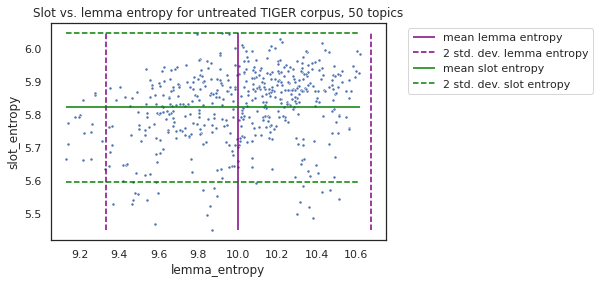

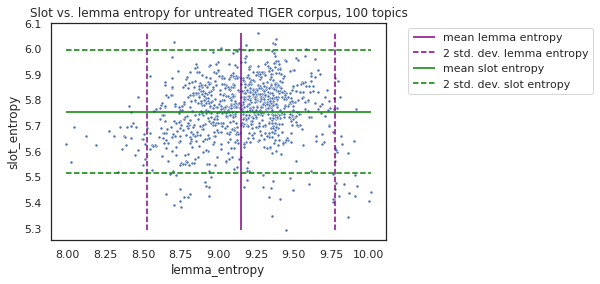

In [38]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    raw_df = df[df['treatment'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    x_data = raw_df["lemma_entropy"]
    x_mean = x_data.mean()
    x_stdev = x_data.std()
    xmax = x_data.max()
    xmin = x_data.min()
    lemma_upper = x_mean + 2*x_stdev
    lemma_lower = x_mean - 2*x_stdev
    y_data = raw_df["slot_entropy"]
    y_mean = y_data.mean()
    y_stdev = y_data.std()
    ymin = y_data.min()
    ymax = y_data.max()
    
    slot_upper = y_mean + 2*y_stdev
    slot_lower = y_mean - 2*y_stdev

    low_lemma_entropy = raw_df[raw_df["lemma_entropy"] <= lemma_lower].sort_values(["lemma_entropy", "slot_entropy"])
    low_lemma_entropy.head()
    print(num_topics, "topic experiments, low lemma entropy:", len(low_lemma_entropy), "topics")
    display(low_lemma_entropy)

    low_slot_entropy = raw_df[raw_df["slot_entropy"] <= slot_lower ].sort_values(["slot_entropy", "lemma_entropy"])
    print(num_topics, "topic_experiments, low slot entropy:", len(low_slot_entropy), "topics")
    display(low_slot_entropy)
    
    plt.vlines(x_mean, ymin, ymax, colors='purple', label="mean lemma entropy")
    plt.vlines(x_mean -2*x_stdev, ymin, ymax, colors='purple', linestyles='--', label="2 std. dev. lemma entropy")
    plt.vlines(x_mean +2*x_stdev, ymin, ymax, colors='purple', linestyles='--', )
    plt.hlines(y_mean, xmin, xmax, colors='green', label="mean slot entropy")
    plt.hlines(y_mean -2*y_stdev, xmin, xmax, colors='green', linestyles='--', label="2 std. dev. slot entropy")
    plt.hlines(y_mean +2*y_stdev, xmin, xmax, colors='green', linestyles='--', )
    sns.scatterplot(data=raw_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name.upper()} corpus, {num_topics} topics")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

    

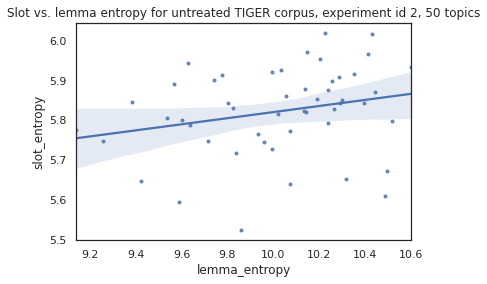

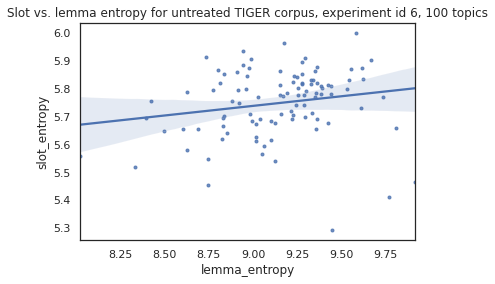

In [19]:
# Compare slot vs lemma entropy for a single experiment
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    experiment_id = random.randrange(10)
    tmp_df = df[df['experiment_id'] == str(experiment_id)]
    tmp_df = tmp_df[tmp_df['treatment'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    sns.regplot(data=tmp_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name.upper()} corpus, experiment id {experiment_id}, {num_topics} topics")

Slope: 0.09543765929701281 Intercept: 4.864623950631684 r: 0.27991343628016047 r^2: 0.07835153181016745
Slot entropy stddev: 0.11976283275126427
Lemma entropy stdev: 0.3512578399447585
Slope: 0.07380291827701789 Intercept: 5.073441359338751 r: 0.1980626276162221 r^2: 0.03922880445824226
Slot entropy stddev: 0.1250932425124846
Lemma entropy stdev: 0.33570889725604924


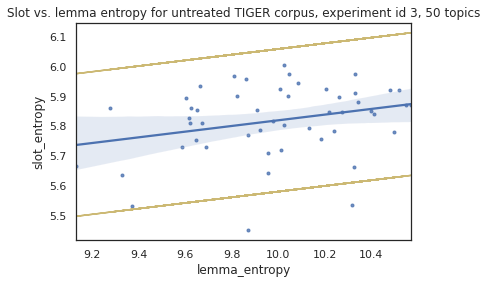

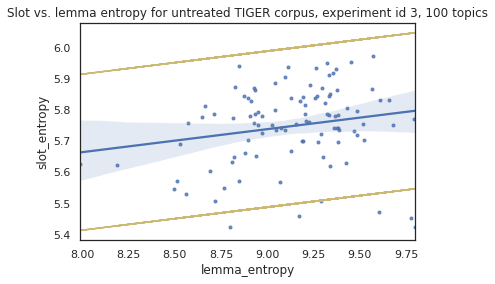

In [20]:
# Compare slot vs lemma entropy for a single experiment
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    experiment_id = random.randrange(10)
    tmp_df = df[df['experiment_id'] == str(experiment_id)]
    tmp_df = tmp_df[tmp_df['treatment'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    x_data = tmp_df["lemma_entropy"]
    y_data = tmp_df["slot_entropy"]
    res = stats.linregress(x_data, y_data)
    print("Slope:", res.slope, "Intercept:", res.intercept, "r:", res.rvalue, "r^2:", res.rvalue**2)
    y_stdev = np.std(y_data)
    print("Slot entropy stddev:", y_stdev)
    x_stdev = np.std(x_data)
    print("Lemma entropy stdev:", x_stdev)
    plt.plot(x_data, res.intercept + res.slope*x_data + 2*y_stdev, 'y')
    plt.plot(x_data, res.intercept + res.slope*x_data - 2*y_stdev, 'y')
    sns.regplot(data=tmp_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name.upper()} corpus, experiment id {experiment_id}, {num_topics} topics")

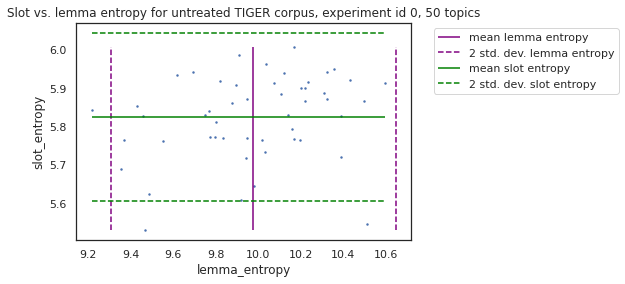

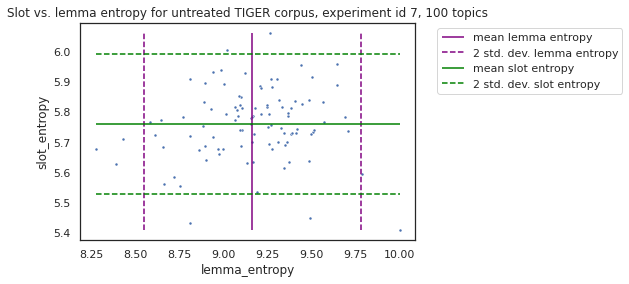

In [21]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    experiment_id = random.randrange(10)
    tmp_df = df[df['experiment_id'] == str(experiment_id)]
    tmp_df = tmp_df[tmp_df['treatment'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    x_data = tmp_df["lemma_entropy"]
    x_mean = x_data.mean()
    x_stdev = x_data.std()
    xmax = x_data.max()
    xmin = x_data.min()
    y_data = tmp_df["slot_entropy"]
    y_mean = y_data.mean()
    y_stdev = y_data.std()
    ymin = y_data.min()
    ymax = y_data.max()
    
    plt.vlines(x_mean, ymin, ymax, colors='purple', label="mean lemma entropy")
    plt.vlines(x_mean -2*x_stdev, ymin, ymax, colors='purple', linestyles='--', label="2 std. dev. lemma entropy")
    plt.vlines(x_mean +2*x_stdev, ymin, ymax, colors='purple', linestyles='--', )
    plt.hlines(y_mean, xmin, xmax, colors='green', label="mean slot entropy")
    plt.hlines(y_mean -2*y_stdev, xmin, xmax, colors='green', linestyles='--', label="2 std. dev. slot entropy")
    plt.hlines(y_mean +2*y_stdev, xmin, xmax, colors='green', linestyles='--', )
    sns.scatterplot(data=tmp_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name.upper()} corpus, experiment id {experiment_id}, {num_topics} topics")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [22]:
raw_df.sort_values(['lemma_entropy', 'slot_entropy'], inplace=True)
print("Topics with no treatment, sorted by ascending lemma entropy and slot entropy")
print("Head - low lemma entropy")
display(raw_df.head(5))
print("Tail - high lemma entropy")
raw_df.tail(5)

Topics with no treatment, sorted by ascending lemma entropy and slot entropy
Head - low lemma entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
5966,3,66,100,7.989229,5.626755,walesa erreichte polen stichwahl warschau walesas kuron danziger präsident hochrechnungen polnische aleksander kwasniewski kwasniewskis vermögenserklärung polnischen lech edith heller polens,walesa polen erreichen stichwahl warschau hochrechnung kuron danziger pawlak präsident aleksander kwasniewski vermögenserklärung ex-kommunist pole lech edith polnisch heller katholisch,walesa aleksander stichwahl kwasniewski warschau walesas polen lech edith kuron danziger hochrechnung polnisch heller präsident vermögenserklärung pole erreichen,ex-kommunist katholisch pawlak,18,3
5004,6,4,100,8.020892,5.559762,kohl gegenzug rexrodt günter wirtschaft kanzlers delegation kanzler kohls hanoi deutschland deutscher bundeskanzler regierungschef deutschen vietnam vietnamesen deutsche gastgeber helmut,deutsch kohl gegenzug rexrodt günter wirtschaft delegation kanzler vietnamese ho-chi-minh-stadt hanoi deutschland bundeskanzler ansprechen regierungschef vietnam besuch deutsche gastgeber helmut,kohls regierungschef hanoi deutsch deutschland kohl vietnam delegation gegenzug rexrodt günter wirtschaft deutsche gastgeber bundeskanzler helmut kanzler vietnamese,ansprechen besuch ho-chi-minh-stadt,18,3
5821,0,21,100,8.038486,5.696939,heller kuron polens aleksander kwasniewski lech walesa sonntag stichwahl erreichte warschau kwasniewskis wähler polen prozent polnische kandidaten sieger polnischen walesas,katholisch heller kuron ex-kommunist aleksander kwasniewski lech walesa sonntag stichwahl warschau hochrechnung polnisch pole wähler polen prozent sieger kandidat erreichen,sonntag pole sieger erreichen heller stichwahl kuron aleksander kwasniewski wähler lech warschau polen walesas prozent walesa kandidat polnisch,hochrechnung katholisch ex-kommunist,18,3
4513,2,13,100,8.119369,5.661507,polen walesa polens präsident danziger heller walesas lech polnischen warschau umfragen amtsinhaber kuron aleksander vermögenserklärung kwasniewski kwasniewskis stichwahl polnische edith,polen walesa ex-kommunist präsident danziger heller lech warschau pawlak amtsinhaber kuron aleksander vermögenserklärung kwasniewski umfrage pole polnisch stichwahl katholisch edith,polen danziger heller walesas kwasniewski walesa lech umfrage pole präsident polnisch stichwahl amtsinhaber kuron aleksander vermögenserklärung warschau edith,pawlak ex-kommunist katholisch,18,3
5986,3,86,100,8.186994,5.624011,usa us-präsident clintons kongreß dollar veto präsident washington republikaner dienstag demokraten perot präsidenten bill clinton republikanern newt gingrich powell republikanischen,usa us-präsident kongreß dollar demokrat veto präsident washington republikaner amerikanisch haushalt perot bill haus republikanisch clinton weiß gesetz gingrich powell,usa clinton kongreß us-präsident dollar perot newt demokrat dienstag gingrich veto wahington bill washington republikaner präsident powell republikanisch,amerikanisch haushalt weiß gesetz haus,18,5


Tail - high lemma entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
5631,4,81,100,9.908346,5.427390,bleibt fast lassen wissen frage rolle sehen geben läßt steht weg menschen politik meisten leben eher politische gilt sogar trotz,bringen lassen gelten alt wissen frage führen problem politisch sehen nehmen geben finden bleiben politik zeigen leben mensch stehen müssen,fragen fast meiste lassen gelten wissen frage meister rolle politisch sehen geben weg bleiben politik meisten leben eher mensch sogar stehen trotz,alt finden bringen führen müssen problem nehmen zeigen,22,8
4501,2,1,100,9.910855,5.763969,staat könnten müsse deutschland müßten bleiben deutschen deutsche könne stellen entwicklung frage zukunft weg lassen europäischen bonn gesellschaft erhalten europa,können deutsch staat ziel deutschland bleiben stellen künftig entwicklung stark führen frage weg problem europäisch land müssen international bonn europa,können deutsch staat deutschland bleiben deutsche stellen entwicklung frage zukunft weg lassen fragen europäisch stelle bonn müssen gesellschaft erhalten europa bleibe,land international stark führen ziel künftig problem,21,7
5090,6,90,100,9.919239,5.465408,lassen land politischen bleibt sogar politische zukunft frage menschen weg eher politik meisten rolle steht läßt obwohl gilt fast bleiben,lassen problem land setzen bringen sehen halten nehmen führen stehen frage liegen weg stellen geben mensch finden politisch fast bleiben,lassen land sogar fragen bleibe stehen zukunft frage gelten weg eher politik meisten mensch rolle meiste obwohl politisch meister fast bleiben,führen liegen problem setzen finden bringen stellen sehen halten geben nehmen,21,11
4790,7,40,100,10.001373,5.407424,land steht fast menschen sogar bleibt liegt frage weg leben schließlich welt lassen gesellschaft meisten letzten läßt eher gilt alten,geben land alt wissen nehmen bleiben frage weg stehen leben finden politisch bringen stellen lassen mensch führen halten sehen zeigen,gelten land alt alte fast sogar fragen bleiben letzter frage weg stehen leben schließlich welt lassen gesellschaft meister mensch meiste eher liegen,geben führen wissen halten finden nehmen sehen politisch bringen stellen zeigen,22,11
4523,2,23,100,10.011504,5.441909,bleibt wissen eher menschen leben sogar fast art schließlich leute sehen gilt welt liegt lassen läßt steht land alten meisten,wissen mensch leben gelten sogar geben bleiben liegen bringen fast sehen alt stehen lassen finden land müssen halten politisch zeigen,meiste wissen eher mensch leben gelten sogar bleiben liegen alte fast art schließlich leute sehen alt welt stehen lassen meister land meisten,müssen bringen halten politisch zeigen geben finden,22,7


In [23]:
raw_df.sort_values(['slot_entropy', 'lemma_entropy'], ascending=[True, False], inplace=True)
print("Topics with no treatment, sorted by ascending slot entropy, then descending lemma entropy")
print("Head - low slot entropy")
display(raw_df.head(5))
print("Tail - high slot entropy")
raw_df.tail(5)

Topics with no treatment, sorted by ascending slot entropy, then descending lemma entropy
Head - low slot entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
5053,6,53,100,9.448064,5.291285,seite parlament mehrheit kommenden entscheidung amt november vorsitzende mittwoch präsident kritik dienstag jahres partei erklärt regierung woche dezember zustimmung ministerpräsident,seite erklären parlament äußern mehrheit entscheidung vorsitzend kommend amt fordern ministerpräsident november mitglied präsident kritik dienstag regierung abgeordneter dezember woche,seite parlament erklären mehrheit entscheidung vorsitzender vorsitzend kommend amt november mittwoch präsident kritik dienstag partei regierung woche dezember zustimmung jahr ministerpräsident,abgeordneter äußern mitglied fordern,21,4
5280,8,30,100,9.857814,5.344453,sagen eher steht lassen mal sehen sogar leute halten läßt rolle wissen art gilt schließlich frage alten weg bleibt fast,bleiben nehmen eher gelten stehen lassen müssen mal sehen sogar leute halten finden zeigen bringen wissen art frage alt fast,sagen eher bleiben gelten stehen lassen mal sehen sogar leute halten rolle wissen art alte schließlich frage weg fragen alt fast,nehmen müssen zeigen finden bringen,21,5
4581,2,81,100,9.353866,5.348320,november afp angaben präsident abend ministerpräsident montag regierung rtr erklärte woche entscheidung mittwoch dienstag sprecher donnerstag samstag dpa ap freitag,november präsident abend vorsitzend ministerpräsident angabe montag regierung gespräch woche entscheidung mittwoch dienstag donnerstag fordern berichten dpa erklären ap freitag,november afp erklärt präsident abend ministerpräsident angabe montag regierung rtr woche entscheidung mittwoch dienstag sprecher donnerstag samstag dpa erklären ap freitag,gespräch fordern berichten vorsitzend,21,4
5315,8,65,100,8.750893,5.383959,spd scharpings lafontaines mannheim vorstand wolfgang parteichef partei lafontaine sozialdemokraten oskar stimmen rudolf delegierten rau antrag schröder wahl parteitag scharping,stimme spd mannheim delegierter vorstand ministerpräsident wolfgang parteichef partei lafontaine oskar rudolf antrag spd-vorsitzender vorsitzend schröder stellvertretend wahl parteitag scharping,stimme spd mannheim delegierter vorstand wolfgang parteichef partei lafontaine oskar stimmen rudolf sozialdemokrat rau antrag schröder wahl parteitag scharping delegierte,ministerpräsident spd-vorsitzender vorsitzend stellvertretend,20,4
5573,4,23,100,8.703699,5.391674,vorstand mannheim scharping lafontaine schröder parteichef sozialdemokraten partei scharpings lafontaines rudolf ministerpräsident spd parteitag stellvertretende oskar rau wahl gerhard delegierten,vorstand mannheim scharping lafontaine schröder vorsitzend parteichef wählen partei sozialdemokrat rudolf delegierter stellvertretend ministerpräsident spd parteitag oskar rau wahl gerhard,vorstand mannheim scharping lafontaine schröder delegierte parteichef partei sozialdemokrat rudolf delegierter stellvertretend ministerpräsident spd parteitag oskar rau wahl gerhard,wählen vorsitzend,19,2


Tail - high slot entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
5300,8,50,100,9.374745,6.020493,ringo mccartney wissenschaften beatles martin theologie millionen queen paul emi freddie griechischen studien john alten george kenntnis songs anthology schönen,wissenschaft mccartney beatles martin theologie song queen lennon paul schön britisch studium mercury george kenntnis griechische lateinische million alt anthology,ringo mccartney wissenschaft wissenschaften beatles griechisch martin theologie song queen paul schön studie emi freddie studium alte john george kenntnis griechische million alt songs anthology,lateinische lennon mercury britisch,25,4
4503,2,3,100,9.360795,6.021990,davos hongkonger snowboarder pfund slowakische labour michaels london minderheit davoser patten blair harpen city rey britischen colt party gerber slowakei,davos hongkonger snowboarder pfund labour ungarisch michaels london minderheit slowakisch patten blair harpen alt rey britisch colt party gerber slowakei,davos hongkonger snowboarder pfund labour michaels london minderheit davoser slowakisch patten blair harpen city rey britisch colt party gerber slowakei,ungarisch alt,20,2
5405,5,55,100,8.707010,6.025411,cimi chrétien brasilianischen völker organisationen ausgelöst cardoso heidegger ureinwohner dekret hannah heideggers ettingers martin ausweisung indigenen arendt arendts gebiet new,brasilien cimi indianisch ettinger wolin organisation kanada brasilianisch heidegger ureinwohner volk dekret hannah martin safranski auslösen indigen arendt gebiet new,ettinger martin cimi heidegger ausweisung chrétien auslösen ureinwohner indigen arendt organisation dekret gebiet volk brasilianisch hannah new cardoso,brasilien safranski wolin indianisch kanada,18,5
5643,4,93,100,9.382944,6.039959,schrift lateinischen wissenschaften studien heymann studium aristoteles alten mathematikunterricht griechischen griechische philosophie sächsische wein weine kenntnis hungarovin mathematik theologie unseres,schrift alt heymann dein studium wissenschaft aristoteles heilig weinberg griechische mathematikunterricht philosophie wein lateinische sitte sächsisch kenntnis hungarovin mathematik theologie,schrift griechisch lateinisch studie alt wissenschaften heymann studium wissenschaft aristoteles griechische mathematikunterricht unser philosophie alte wein mein lateinische sächsisch kenntnis hungarovin mathematik theologie,heilig sitte weinberg dein,23,4
4810,7,60,100,9.264763,6.062950,san heidegger aung studien arendt theologie arendts ettingers suu wissenschaften schüler philosophie griechischen hannah kyi rangun burma eure alten bagan,san wissenschaft studium lateinische schön heidegger aung arendt theologie ettinger suu schüler philosophie kyi hannah dein rangun wolin burma griechische,san alt alte wissenschaft studium heidegger aung arendt theologie ettinger suu wissenschaften studie philosophie schüler kyi hannah dein rangun griechisch burma euer griechische bagan,wolin lateinische schön,24,3


# Metrics dealing with the top terms and top lemmas for a topic
This covers exclusivity, ratios of morphological features to terms, lemmas covered or excluded by top terms. 

Treatment reduces exclusivity of the word type used by the topic model. 
Word types being more exclusive than lemmas means there's at least one word type that is concentrated in a particular topic. 


The number of lemmas in the top 20 terms (and the ratio of lemmas to top 20 forms) shows how much conflation each treatment causes - in the topic's key terms. Truncation and Stanza cause the most. Surprisingly, snowball doesn't have as large an effect. 

<Figure size 432x288 with 0 Axes>

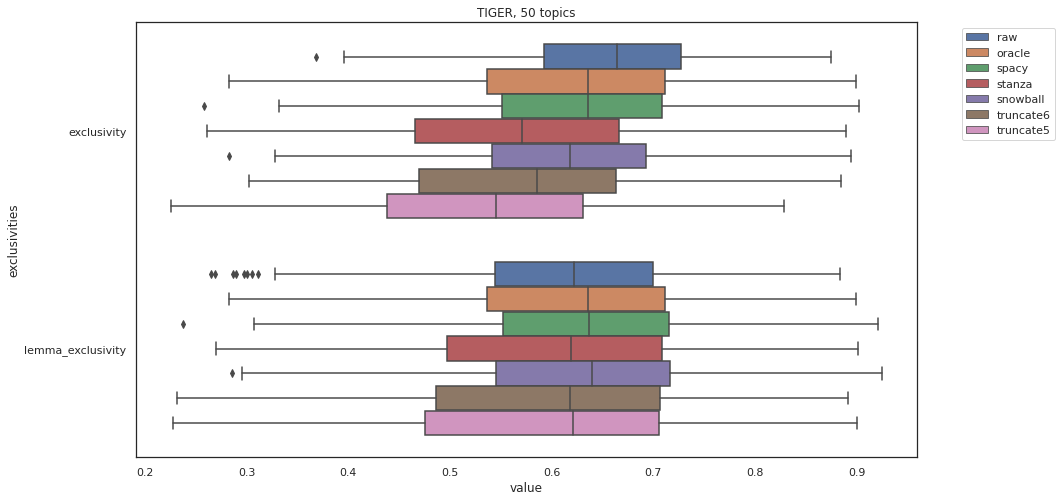

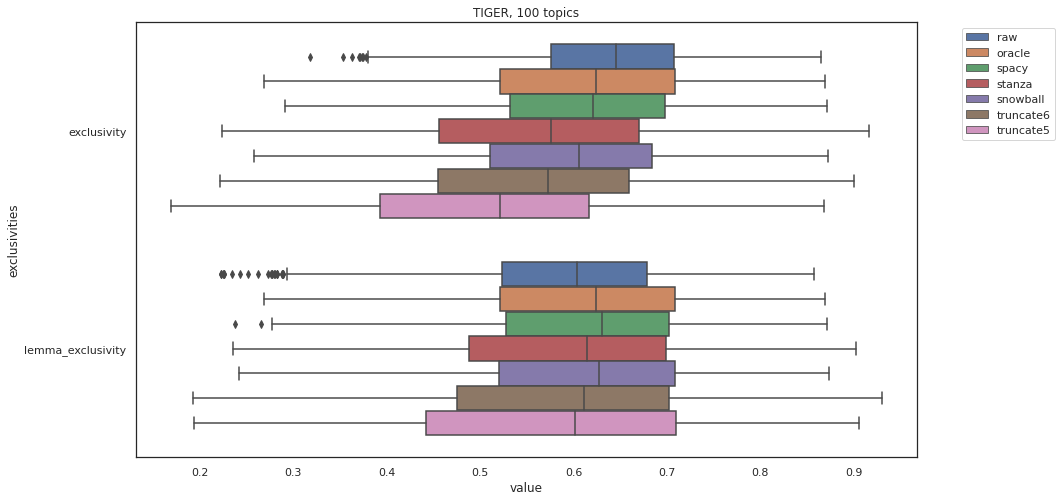

In [24]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    exclusivity_metrics = ['exclusivity', 'lemma_exclusivity']#, 'lemmas_to_top_20_surface_forms', 'slots_to_top_20_surface_forms', 'pos_to_top_20_surface_forms']
    exclusivity_stats = pd.melt(df, "treatment", var_name="exclusivities", value_vars=exclusivity_metrics)

    fig, axs = plt.subplots(figsize=(14, 8))
    sns.boxplot(x="value", y="exclusivities", hue="treatment", data=exclusivity_stats, hue_order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

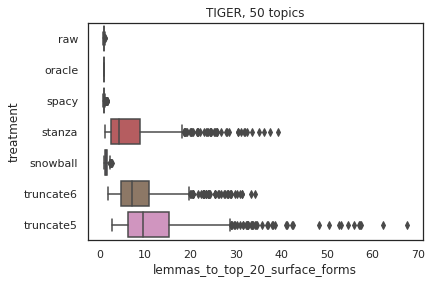

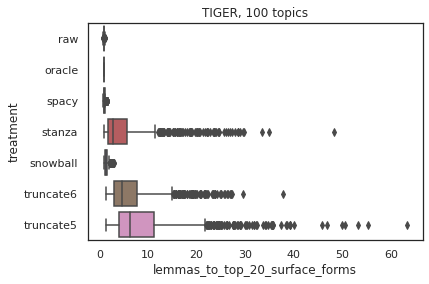

In [25]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='lemmas_to_top_20_surface_forms', y='treatment', data=df, order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

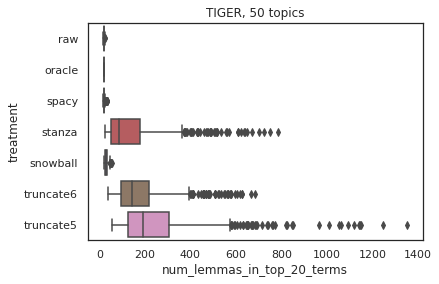

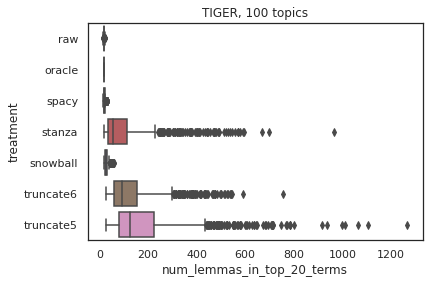

In [26]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='num_lemmas_in_top_20_terms', y='treatment', data=df, order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

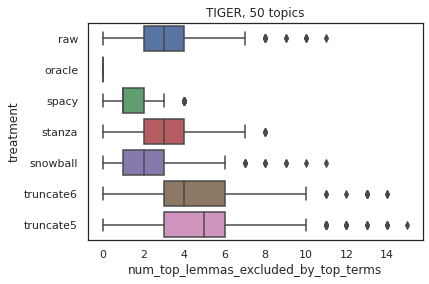

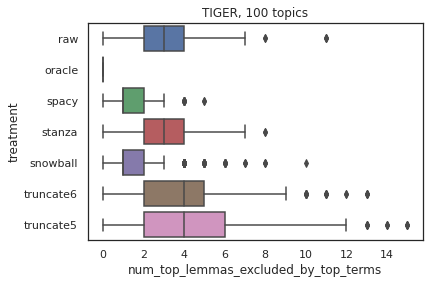

In [27]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='num_top_lemmas_excluded_by_top_terms', y='treatment', data=df, order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

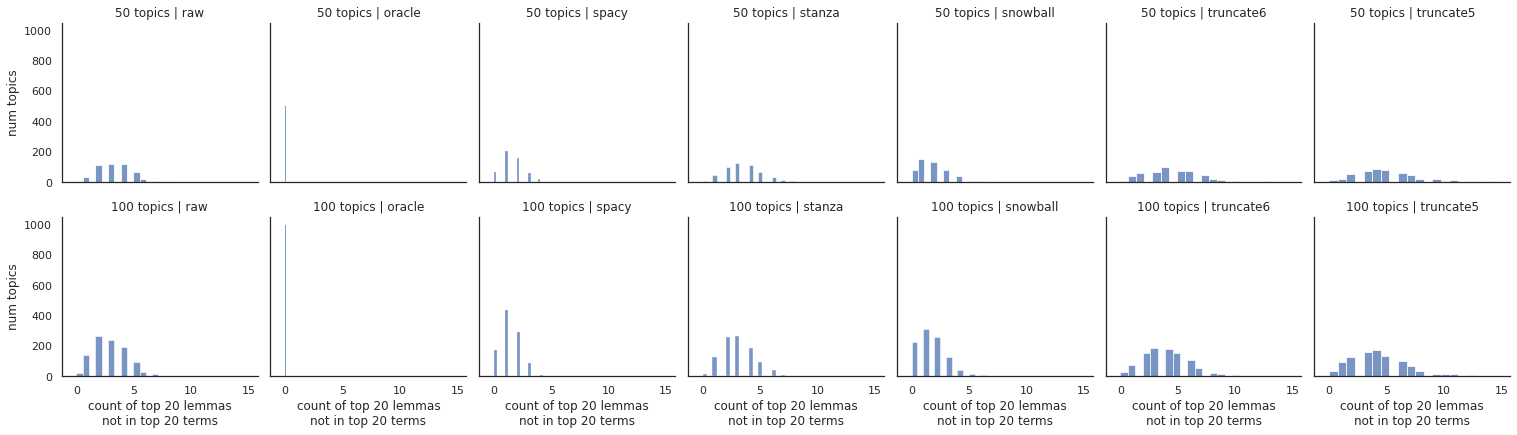

In [61]:
g = sns.FacetGrid(full_frame, col="treatment", row="num_topics", col_order=hue_order)
g.map(sns.histplot, "num_top_lemmas_excluded_by_top_terms", bins=20)
g.set_titles(col_template="{col_name}", row_template= "{row_name} topics")
g.set_axis_labels("count of top 20 lemmas\nnot in top 20 terms", "num topics")

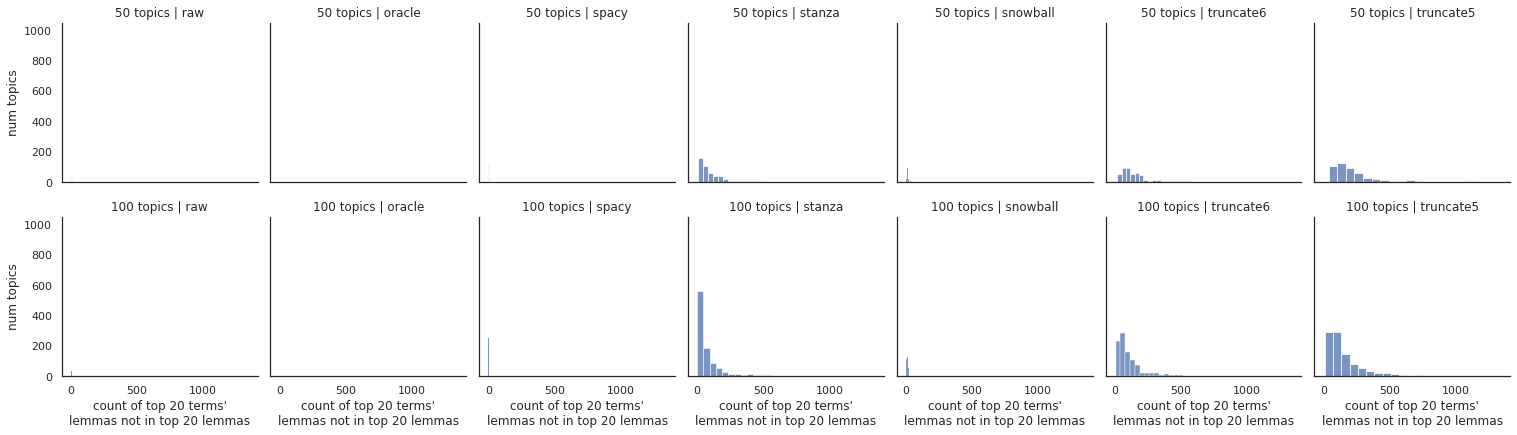

In [60]:
g = sns.FacetGrid(full_frame, col="treatment", row="num_topics", col_order=hue_order)
g.map(sns.histplot, "num_top_term_lemmas_excluded_by_top_lemmas" , bins=20)
g.set_titles(col_template="{col_name}", row_template= "{row_name} topics")
g.set_axis_labels("count of top 20 terms'\nlemmas not in top 20 lemmas", "num topics")

50 topic experiments, num_top_lemmas_excluded_by_top_terms, means: 3.466 stdev: 1.6559977830041408 count upper end outliers: 21 out of 500
Max top lemmas excluded by top terms: 11
Max top term lemmas excluded by top lemmas: 14


,topic_id,corpus,treatment,num_topics,experiment_id,tokens,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity,negative_coherence,lemma_exclusivity,lemma_entropy,slot_entropy,pos_entropy,lemmas_to_top_20_surface_forms,slots_to_top_20_surface_forms,pos_to_top_20_surface_forms,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,top_term_lemmas_minus_top_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms,num_top_term_lemmas_excluded_by_top_lemmas
5246,46,tiger,raw,50,4,53363.0,6.5992,5.70,-320.5085,3.6121,1.4113,1061.0559,0.0010,0.0630,0.0008,0.0517,0.4720,320.5085,0.3107,10.380138,5.487797,2.933215,1.10,3.75,0.60,weg gesellschaft meisten politische land arbeit fast lassen art menschen steht sogar eher frage bleibt schließlich geben politik läßt leben,sehen land finden bringen mensch stellen führen lassen problem halten bleiben frage nehmen geben zeigen wissen stehen politisch liegen leben,weg gesellschaft meisten land fragen mensch arbeit fast lassen art sogar meiste eher bleiben frage schließlich geben meister stehen politik politisch leben,sehen zeigen wissen halten nehmen führen problem finden bringen liegen stellen,meister fast eher weg art gesellschaft meisten politik fragen schließlich sogar meiste arbeit,22,11,13
5785,35,tiger,raw,50,0,58171.0,6.6140,5.65,-315.9347,3.5017,1.3083,1203.1662,0.0010,0.0715,0.0008,0.0843,0.4615,315.9347,0.2969,10.512262,5.545143,2.933057,1.10,3.80,0.60,lassen land menschen politische halten eher steht sogar weg frage fast gilt meisten läßt bleibt art arbeit politik schließlich leben,bringen lassen land problem finden gelten mensch halten bleiben nehmen weg zeigen frage stellen sehen alt stehen geben wissen politisch,fragen lassen land meiste gelten mensch halten eher bleiben sogar weg frage fast meisten meister stehen art arbeit politik schließlich politisch leben,alt geben bringen stellen nehmen problem wissen zeigen sehen finden,fragen fast leben eher art arbeit sogar politik schließlich meiste meisten meister,22,10,12
4977,27,tiger,raw,50,2,60620.0,6.6631,6.15,-339.7415,3.5043,1.2654,1225.9359,0.0010,0.0846,0.0000,0.0934,0.3960,339.7415,0.2893,10.484837,5.611129,2.934913,1.20,4.50,0.55,sogar gilt trotz fast deutschland eher weg land menschen gesellschaft könnten frage steht deutschen meisten sieht politik lassen bleibt arbeit,nehmen führen problem können politisch sehen land halten gelten deutsch stellen zeigen bleiben müssen neu geben stehen frage lassen mensch,sogar trotz können fast deutschland eher sehen weg land gelten gesellschaft deutsch bleiben deutsche meiste stehen frage meisten fragen politik meister lassen arbeit mensch,müssen neu politisch nehmen halten führen problem geben zeigen stellen,sogar deutsche meisten meiste fragen weg trotz politik meister arbeit fast deutschland gesellschaft eher,24,10,14
5715,15,tiger,raw,50,5,50265.0,6.6064,5.45,-317.3673,3.6184,1.4424,1042.4310,0.0005,0.0480,0.0000,0.0374,0.5552,317.3673,0.3732,10.359823,5.518701,3.000857,1.10,4.35,0.65,leute fast bleibt leben art gilt lassen meisten schließlich sehen eher stehen deutschen mal läßt steht alten menschen sogar land,bringen führen liegen leben halten alt lassen nehmen finden sehen deutsch stehen wissen mensch gelten zeigen grund müssen bleiben sogar,meiste leute fast leben art alt lassen meisten alte schließlich meister sehen eher deutsch stehen mensch gelten mal bleiben deutsche sogar land,zeigen bringen wissen grund müssen führen nehmen finden liegen halten,eher meiste meister leute fast meisten mal deutsche alte schließlich art land,22,10,12
4738,38,tiger,raw,50,9,2292.0,3.1979,7.05,-772.2508,4.1850,4.3609,744.2992,0.0460,0.2909,0.0882,0.2909,0.8581,772.2508,0.8839,9.986275,6.001427,2.238070,1.00,1.20,0.20,festspiele horse bre-x ureinwohner arendts heidegger crazy heckert dm fritz cimi generation ettingers hannah gould gebiete mortier pepsico 

100 topic experiments, num_top_lemmas_excluded_by_top_terms, means: 2.936 stdev: 1.5013854129297242 count upper end outliers: 43 out of 1000
Max top lemmas excluded by top terms: 11
Max top term lemmas excluded by top lemmas: 13


,topic_id,corpus,treatment,num_topics,experiment_id,tokens,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity,negative_coherence,lemma_exclusivity,lemma_entropy,slot_entropy,pos_entropy,lemmas_to_top_20_surface_forms,slots_to_top_20_surface_forms,pos_to_top_20_surface_forms,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,top_term_lemmas_minus_top_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms,num_top_term_lemmas_excluded_by_top_lemmas
5090,90,tiger,raw,100,6,40221.0,6.6171,5.90,-329.7849,3.9958,1.6621,789.9294,0.0010,0.0387,0.0000,0.0113,0.3981,329.7849,0.2266,9.919239,5.465408,2.942046,1.05,3.95,0.55,lassen land politischen bleibt sogar politische zukunft frage menschen weg eher politik meisten rolle steht läßt obwohl gilt fast bleiben,lassen problem land setzen bringen sehen halten nehmen führen stehen frage liegen weg stellen geben mensch finden politisch fast bleiben,lassen land sogar fragen bleibe stehen zukunft frage gelten weg eher politik meisten mensch rolle meiste obwohl politisch meister fast bleiben,führen liegen problem setzen finden bringen stellen sehen halten geben nehmen,rolle meiste fragen obwohl bleibe eher sogar politik meister zukunft meisten gelten,21,11,12
5870,70,tiger,raw,100,0,35728.0,6.6452,6.45,-370.2712,4.0444,1.7682,787.1725,0.0009,0.0414,0.0000,0.0073,0.4550,370.2712,0.2229,9.860825,5.591904,2.962503,1.10,2.80,0.45,steht bislang sieht nächsten probleme weg bleiben arbeit entwicklung fall angesichts trotz rolle hält könnten bleibt prozent deutlich stehen stellen,können stark liegen setzen bleiben arbeit entwicklung fall wichtig lassen problem international geben neu halten hoch gelten stehen führen stellen,können bislang nah nächster stelle weg bleiben arbeit entwicklung fall angesichts nächste trotz rolle prozent sehen deutlich problem halten stehen bleibe stellen,international setzen geben lassen neu stark liegen hoch gelten führen wichtig,rolle stelle bleibe weg bislang trotz nah nächster deutlich prozent sehen angesichts nächste,22,11,13
4790,40,tiger,raw,100,7,47158.0,6.6031,5.70,-324.3760,3.8867,1.5384,874.9303,0.0009,0.0582,0.0000,0.0283,0.4066,324.3760,0.2225,10.001373,5.407424,2.954733,1.10,4.45,0.55,land steht fast menschen sogar bleibt liegt frage weg leben schließlich welt lassen gesellschaft meisten letzten läßt eher gilt alten,geben land alt wissen nehmen bleiben frage weg stehen leben finden politisch bringen stellen lassen mensch führen halten sehen zeigen,gelten land alt alte fast sogar fragen bleiben letzter frage weg stehen leben schließlich welt lassen gesellschaft meister mensch meiste eher liegen,geben führen wissen halten finden nehmen sehen politisch bringen stellen zeigen,gelten schließlich alte meiste fast eher liegen sogar welt fragen letzter gesellschaft meister,22,11,13
5631,81,tiger,raw,100,4,40362.0,6.6049,5.45,-322.9832,4.0144,1.6847,750.7187,0.0011,0.0355,0.0000,0.0129,0.4353,322.9832,0.2522,9.908346,5.427390,2.971675,1.10,3.50,0.50,bleibt fast lassen wissen frage rolle sehen geben läßt steht weg menschen politik meisten leben eher politische gilt sogar trotz,bringen lassen gelten alt wissen frage führen problem politisch sehen nehmen geben finden bleiben politik zeigen leben mensch stehen müssen,fragen fast meiste lassen gelten wissen frage meister rolle politisch sehen geben weg bleiben politik meisten leben eher mensch sogar stehen trotz,alt finden bringen führen müssen problem nehmen zeigen,weg eher meister rolle fragen fast sogar meiste meisten trotz,22,8,10
5322,72,tiger,raw,100,8,27813.0,6.6423,7.55,-380.1514,4.2077,1.9333,571.4033,0.0014,0.0309,0.0000,0.0109,0.3535,380.1514,0.2257,9.710665,5.811880,2.929901,1.20,4.00,0.40,stellen deutsche ländern hält deutschen zukunft unternehmen stehen könnten usa nächsten bislang internationalen deutschland sieht ziel entwicklung firmen kosten frankfurt,beste

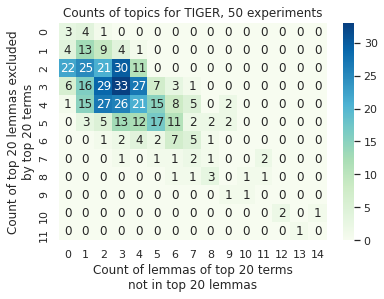

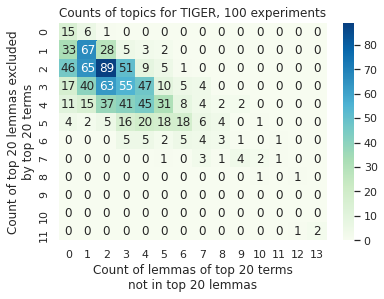

In [81]:
# Visualize the relationships between excluded lemmas and terms
for i, pair in enumerate(num_topics_splits):
    plt.figure(i)
    num_topics, df = pair
    raw_df = df[df["treatment"] == "raw"]
    mean_num_lemmas_excluded = raw_df['num_top_lemmas_excluded_by_top_terms'].mean()
    std_dev = raw_df["num_top_lemmas_excluded_by_top_terms"].std()
    filtered = raw_df[raw_df["num_top_lemmas_excluded_by_top_terms"] >= mean_num_lemmas_excluded + 2*std_dev].sort_values("num_top_lemmas_excluded_by_top_terms", ascending=False)
    print(num_topics, "topic experiments, num_top_lemmas_excluded_by_top_terms, means:", mean_num_lemmas_excluded, "stdev:", std_dev, "count upper end outliers:", len(filtered), "out of", len(raw_df))

    max_top_lemmas_excluded_by_top_terms = raw_df["num_top_lemmas_excluded_by_top_terms"].max()
    print("Max top lemmas excluded by top terms:", max_top_lemmas_excluded_by_top_terms)
    max_top_terms_excluded_by_top_lemmas = raw_df["num_top_term_lemmas_excluded_by_top_lemmas"].max()
    print("Max top term lemmas excluded by top lemmas:", max_top_terms_excluded_by_top_lemmas)

    counts = np.zeros((max_top_lemmas_excluded_by_top_terms +1, max_top_terms_excluded_by_top_lemmas +1))

    for j in range(max_top_lemmas_excluded_by_top_terms + 1):
        for k in range(max_top_terms_excluded_by_top_lemmas + 1):
            counts[j,k] = len(raw_df[(raw_df["num_top_lemmas_excluded_by_top_terms"] == j) & (raw_df['num_top_term_lemmas_excluded_by_top_lemmas']==k)])


    g = sns.heatmap(counts, annot=True, cmap="GnBu")
    g.set(title=f"Counts of topics for {corpus_name.upper()}, {num_topics} experiments", ylabel = "Count of top 20 lemmas excluded\nby top 20 terms", xlabel="Count of lemmas of top 20 terms\nnot in top 20 lemmas")
    
    display(filtered)

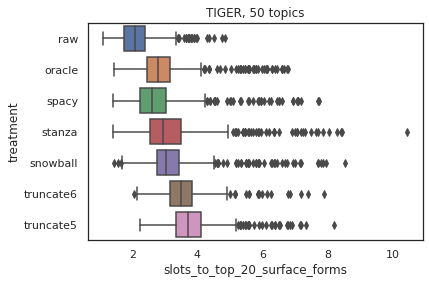

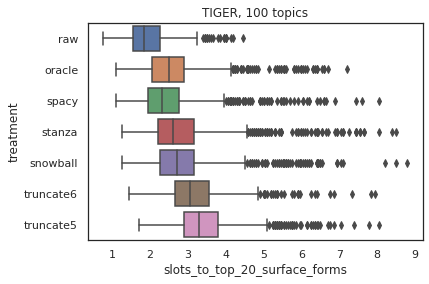

In [28]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='slots_to_top_20_surface_forms', y='treatment', data=df, order=hue_order).set_title(f"{corpus_name.upper()}, {num_topics} topics")

In [29]:
# Sanity check - oracle exlusivity and oracle post-lemmatize exclusivity should be the same
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    oracle_df = df[df["treatment"] == "oracle"]
    print("Num_topics:", num_topics)
    print("\tOracle exclusivity:", oracle_df['exclusivity'].mean())
    print("\tOracle lemma (post-lemmatize) exclusivity:", oracle_df['lemma_exclusivity'].mean())

Num_topics: 50
	Oracle exclusivity: 0.6248644
	Oracle lemma (post-lemmatize) exclusivity: 0.6248644
Num_topics: 100
	Oracle exclusivity: 0.6116086000000001
	Oracle lemma (post-lemmatize) exclusivity: 0.6116086000000001


# Variation of Information

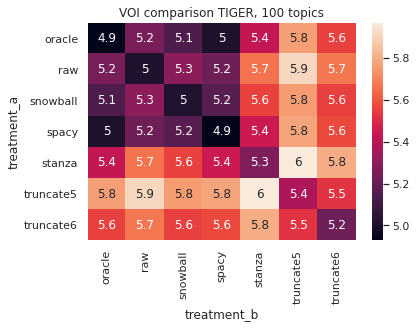

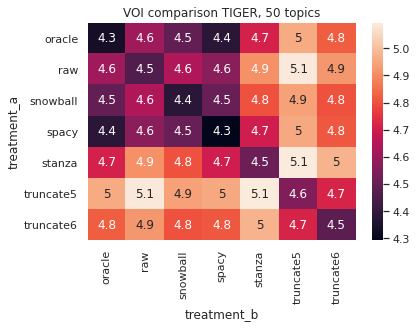

In [30]:
for i, voi in enumerate(voi_folders):
    num_topics = voi.name.split("_")[1]
    voi_frame = parse_voi_directory(voi)
    voi_means = voi_frame.groupby(["treatment_a", "treatment_b"], as_index=False)["voi"].mean()
    voi_means = voi_means.pivot(index="treatment_a", columns="treatment_b", values="voi")
    plt.figure(i)
    sns.heatmap(voi_means, annot=True).set_title(f"VOI comparison {corpus_name.upper()}, {num_topics} topics")


# General diagnostics
These are the standard diagnostics produced by Mallet

In [31]:
full_frame.columns

Index(['topic_id', 'corpus', 'treatment', 'num_topics', 'experiment_id',
       'tokens', 'document_entropy', 'word-length', 'coherence',
       'uniform_dist', 'corpus_dist', 'eff_num_words', 'token-doc-diff',
       'rank_1_docs', 'allocation_ratio', 'allocation_count', 'exclusivity',
       'negative_coherence', 'lemma_exclusivity', 'lemma_entropy',
       'slot_entropy', 'pos_entropy', 'lemmas_to_top_20_surface_forms',
       'slots_to_top_20_surface_forms', 'pos_to_top_20_surface_forms',
       'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms',
       'top_lemmas_minus_top_term_lemmas', 'top_term_lemmas_minus_top_lemmas',
       'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms',
       'num_top_term_lemmas_excluded_by_top_lemmas'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

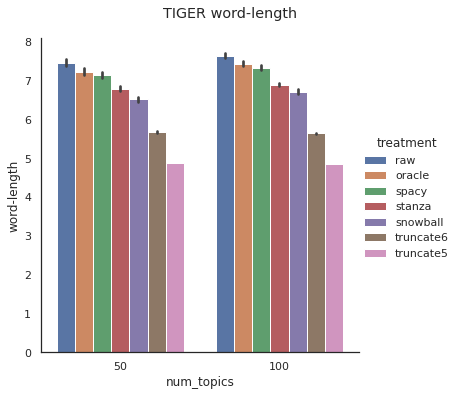

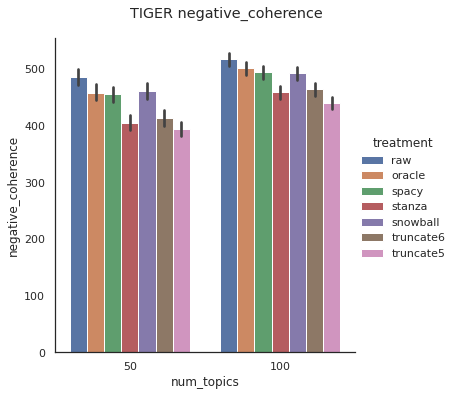

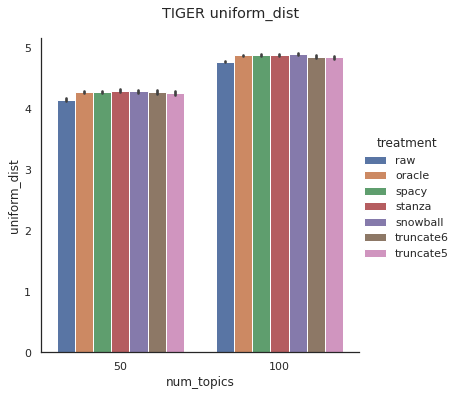

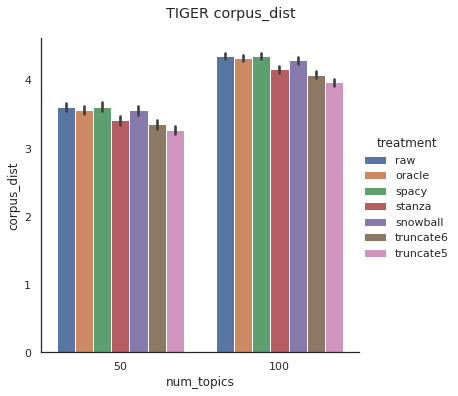

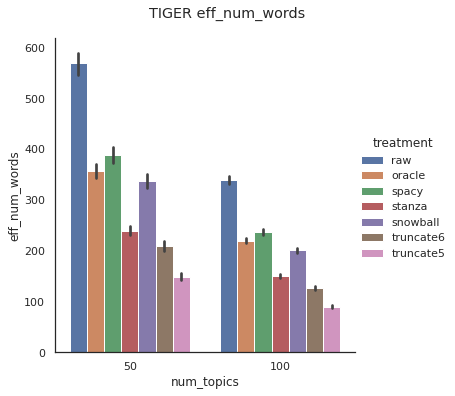

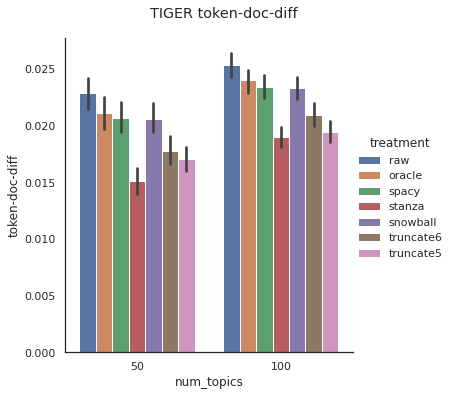

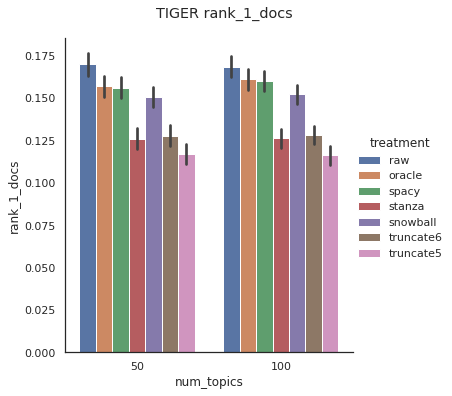

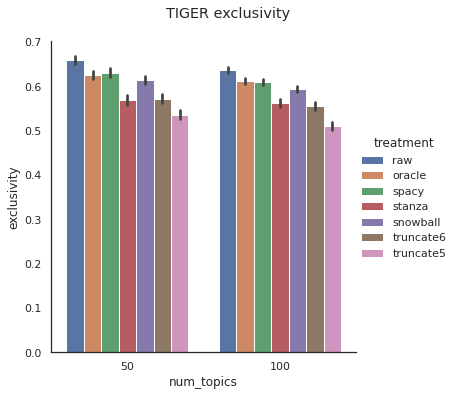

In [33]:
mallet_diagnostics = ['word-length', "negative_coherence", 'uniform_dist', 'corpus_dist', 'eff_num_words', 'token-doc-diff', 'rank_1_docs', 'exclusivity']
for i, m in enumerate(mallet_diagnostics):
    plt.figure(i)
    g = sns.catplot(data = full_frame, kind="bar", x="num_topics", y=m, hue="treatment", hue_order=hue_order)
    g.fig.suptitle(f"{corpus_name.upper()} {m}", y=1.05)
